# Prototype Notebook for A Comparative Analysis of Publisher-Curated vs. User-Generated Recipe Success Factors

## 1. Setup and Data Loading

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from fractions import Fraction
from collections import Counter
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from transformers import BertTokenizer, BertModel
from fancyimpute import KNN
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
pd.options.mode.chained_assignment = None 
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from scipy.sparse import hstack

C:\Users\kurze\anaconda3\Lib\site-packages\transformers\utils\generic.py:260: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


In [2]:
# Load data
df_recipes = pd.read_csv('Data/tasty_recipes_combined.csv')

In [3]:
df_recipes

,Recipe Title,Author,Role,Score,Total Time,Prep Time,Cook Time,Ingredients,Preparation Steps,Calories,Fat,Carbs,Fiber,Sugar,Protein,Tags,Recipe URL
0,Roasted Moroccan Carrots With Baba Ganoush,Fiona Anchal,Community Member,NaN,30 minutes,10 minutes,20 minutes,"['1 bunch dutch carrots, washed and tops trimm...",['Place carrots on a baking dish lined with ba...,72.0,4 g,8 g,2 g,2 g,2 g,"['Meal', 'Dinner', 'Weeknight', 'Kosher', 'Hal...",https://tasty.co/recipe/roasted-moroccan-carro...
1,Edamame Truffle Dumplings In Miso Broth,Nimisha Wasankar,Community Member,NaN,1 hr 10 min,40 minutes,30 minutes,"['1 package frozen shelled edamame', '2 tables...",['Cook the frozen edamame according the packag...,413.0,16 g,49 g,6 g,3 g,18 g,"['Cuisine', 'Asian', 'Japanese', 'Soy', 'Glute...",https://tasty.co/recipe/edamame-truffle-dumpli...
2,Grilled Napa Cabbage Fattoush Salad,Reza Setayesh,Community Member,NaN,40 minutes,20 minutes,20 minutes,"['1 head medium napa cabbage', '1 small red on...",['Preheat the grill and preheat the oven to 37...,430.0,29 g,32 g,2 g,6 g,9 g,"['Cuisine', 'European', 'Mediterranean', 'Kosh...",https://tasty.co/recipe/grilled-napa-cabbage-f...
3,Roasted Tomato Basil Soup,Merle O'Neal,Tasty Team,91% would make again,25 minutes,5 minutes,20 minutes,"['1 tablespoon olive oil', '1 yellow onion, di...","['In a large pot over medium heat, combine the...",48.0,0 g,9 g,1 g,2 g,1 g,"['Meal', 'Dinner', 'Soups', 'Budget', 'High-Fi...",https://tasty.co/recipe/roasted-tomato-basil-soup
4,Tuna Salad With Roasted Veggies,Mercedes Sandoval,Tasty Team,96% would make again,35 minutes,15 minutes,20 minutes,"['1 cup green beans (360 g), trimmed', '2 cups...","['Preheat the oven to 375˚F (190˚C).', 'On a b...",576.0,19 g,51 g,7 g,11 g,49 g,"['Meal', 'Lunch', 'Salads', 'Dairy', 'Fish', '...",https://tasty.co/recipe/tuna-salad-with-roaste...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10245,15-Minute Donuts,Matt Ciampa & Joe Sasto,Tasty Team,87% would make again,15 minutes,7 minutes,8 minutes,"['8 cups canola oil (1.9 L), for frying', '4 t...",['Fill a large pot with 2 inches (5 cm) of can...,490.0,35 g,40 g,1 g,26 g,2 g,"['Cooking Style', 'Deep-Fry', 'Budget', 'Glute...",https://tasty.co/recipe/15-minute-donuts
10246,Vegan Tzatziki,Betsy Carter,Tasty Team,97% would make again,NaN,NaN,NaN,"['12 oz coconut yogurt (340 g)', '1 lemon, jui...","['In a blender or food processor, combine coco...",141.0,7 g,16 g,0 g,11 g,4 g,"['Cuisine', 'European', 'Mediterranean', 'Budg...",https://tasty.co/recipe/vegan-tzatziki
10247,Swiss Roll Pops,NaN,NaN,71% would make again,32 minutes,20 minutes,12 minutes,"['⅔ cup caster sugar (125 g), plus more for du...","['Pre-heat the oven to 200°C (400°F).', 'Add t...",150.0,3 g,25 g,0 g,16 g,2 g,"['Meal', 'Desserts', 'Cakes', 'Budget', 'Sweet...",https://tasty.co/recipe/swiss-roll-pops
10248,Banana Bread Cake Truffles,Tresha Lindo & Chris Salicrup,Tasty Team,94% would make again,2 hr 15 min,30 minutes,50 minutes,"['nonstick cooking spray, for greasing', '3 ri...",['Make the banana bread: Preheat the oven to 3...,315.0,7 g,62 g,4 g,40 g,3 g,"['Seasonal', 'Occasion', 'Party', 'Budget', 'D...",https://tasty.co/recipe/banana-bread-cake-truf...


In [4]:
# Columns to consider for checking duplicates
columns_to_check = ['Recipe Title', 'Score', 'Total Time', 'Prep Time', 'Cook Time', 'Ingredients', 'Preparation Steps']

# Check for duplicates based on these columns
duplicate_rows = df_recipes[df_recipes.duplicated(subset=columns_to_check, keep=False)]

# Count the number of duplicate entries
duplicate_count = duplicate_rows.shape[0]

# Print the count of duplicate entries
print(f"Number of duplicate entries found: {duplicate_count}")

# Print a sample of duplicate entries
if duplicate_count > 0:
    print("Sample duplicate entries:\n", duplicate_rows.head())

Number of duplicate entries found: 6745
Sample duplicate entries:
                                  Recipe Title             Author  \
0  Roasted Moroccan Carrots With Baba Ganoush       Fiona Anchal   
1     Edamame Truffle Dumplings In Miso Broth   Nimisha Wasankar   
2         Grilled Napa Cabbage Fattoush Salad      Reza Setayesh   
4             Tuna Salad With Roasted Veggies  Mercedes Sandoval   
5   Loaded Grill Cheese: The Breath Freshener       Kelsey Weber   

               Role                 Score   Total Time   Prep Time  \
0  Community Member                   NaN   30 minutes  10 minutes   
1  Community Member                   NaN  1 hr 10 min  40 minutes   
2  Community Member                   NaN   40 minutes  20 minutes   
4        Tasty Team  96% would make again   35 minutes  15 minutes   
5        Tasty Team                   NaN   15 minutes  10 minutes   

    Cook Time                                        Ingredients  \
0  20 minutes  ['1 bunch dutch carr

In [5]:
# Remove duplicates based on these columns
df_recipes_cleaned = df_recipes.drop_duplicates(subset=columns_to_check)

# Reset index
df_recipes_cleaned.reset_index(drop=True, inplace=True)

df_recipes_cleaned

,Recipe Title,Author,Role,Score,Total Time,Prep Time,Cook Time,Ingredients,Preparation Steps,Calories,Fat,Carbs,Fiber,Sugar,Protein,Tags,Recipe URL
0,Roasted Moroccan Carrots With Baba Ganoush,Fiona Anchal,Community Member,NaN,30 minutes,10 minutes,20 minutes,"['1 bunch dutch carrots, washed and tops trimm...",['Place carrots on a baking dish lined with ba...,72.0,4 g,8 g,2 g,2 g,2 g,"['Meal', 'Dinner', 'Weeknight', 'Kosher', 'Hal...",https://tasty.co/recipe/roasted-moroccan-carro...
1,Edamame Truffle Dumplings In Miso Broth,Nimisha Wasankar,Community Member,NaN,1 hr 10 min,40 minutes,30 minutes,"['1 package frozen shelled edamame', '2 tables...",['Cook the frozen edamame according the packag...,413.0,16 g,49 g,6 g,3 g,18 g,"['Cuisine', 'Asian', 'Japanese', 'Soy', 'Glute...",https://tasty.co/recipe/edamame-truffle-dumpli...
2,Grilled Napa Cabbage Fattoush Salad,Reza Setayesh,Community Member,NaN,40 minutes,20 minutes,20 minutes,"['1 head medium napa cabbage', '1 small red on...",['Preheat the grill and preheat the oven to 37...,430.0,29 g,32 g,2 g,6 g,9 g,"['Cuisine', 'European', 'Mediterranean', 'Kosh...",https://tasty.co/recipe/grilled-napa-cabbage-f...
3,Roasted Tomato Basil Soup,Merle O'Neal,Tasty Team,91% would make again,25 minutes,5 minutes,20 minutes,"['1 tablespoon olive oil', '1 yellow onion, di...","['In a large pot over medium heat, combine the...",48.0,0 g,9 g,1 g,2 g,1 g,"['Meal', 'Dinner', 'Soups', 'Budget', 'High-Fi...",https://tasty.co/recipe/roasted-tomato-basil-soup
4,Tuna Salad With Roasted Veggies,Mercedes Sandoval,Tasty Team,96% would make again,35 minutes,15 minutes,20 minutes,"['1 cup green beans (360 g), trimmed', '2 cups...","['Preheat the oven to 375˚F (190˚C).', 'On a b...",576.0,19 g,51 g,7 g,11 g,49 g,"['Meal', 'Lunch', 'Salads', 'Dairy', 'Fish', '...",https://tasty.co/recipe/tuna-salad-with-roaste...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6600,Carrot Cake Granola Balls,NaN,NaN,95% would make again,NaN,NaN,NaN,"['1 ¼ cups oats (125 g)', '⅖ cup walnuts (40 g...","['Add oats, walnuts and ground almonds to a la...",167.0,10 g,16 g,2 g,5 g,4 g,"['Meal', 'Dinner', 'Weeknight', 'Budget', 'Pea...",https://tasty.co/recipe/carrot-cake-granola-balls
6601,Date-Nut Energy Balls,Jenny Best,Community Member,NaN,NaN,NaN,NaN,"['1 cup whole almonds (125 g)', '1 cup date (1...",['Put all ingredients in a food processor and ...,80.0,5 g,7 g,1 g,4 g,2 g,"['Meal', 'Snacks', 'Kosher', 'Halal', 'Tree nu...",https://tasty.co/recipe/date-nut-energy-balls
6602,Cheesy Pretzel Ring Dip,Jody Duits,Tasty Team,95% would make again,1 hr,30 minutes,30 minutes,"['32 oz pizza dough (910 g)', '5 cups water (1...","['Preheat the oven to 425°F (220°C).', 'Cut pi...",418.0,23 g,36 g,1 g,2 g,15 g,"['Seasonal', 'Occasion', 'Party', 'Budget', 'D...",https://tasty.co/recipe/cheesy-pretzel-ring-dip
6603,Pigs In A Blanket Stadium,Alvin Zhou,Tasty Team,90% would make again,2 hr 45 min,30 minutes,2 hr 15 min,"['4 sheets puff pastry, chilled', '2 eggs, bea...","['Preheat oven to 350°F (180°C).', 'Roll out t...",531.0,44 g,16 g,0 g,0 g,17 g,"['Seasonal', 'Occasion', 'Game Day', 'Dairy', ...",https://tasty.co/recipe/pigs-in-a-blanket-stadium


In [8]:
# Identify rows with empty "Recipe Title"
empty_title_rows = df_recipes_cleaned[df_recipes_cleaned['Recipe Title'].isnull() | (df_recipes_cleaned['Recipe Title'].str.strip() == '')]

# Display those rows to check if there is any content
print("Rows with empty titles:")
print(empty_title_rows)

Rows with empty titles:
   Recipe Title Author Role Score Total Time Prep Time Cook Time Ingredients  \
15          NaN    NaN  NaN   NaN        NaN       NaN       NaN          []   

   Preparation Steps  Calories  Fat Carbs Fiber Sugar Protein Tags  \
15                []       NaN  NaN   NaN   NaN   NaN     NaN   []   

                                           Recipe URL  
15  https://tasty.co/recipe/jeris-filipino-style-b...  


In [9]:
# Remove rows with empty "Recipe Title"
df_recipes_cleaned = df_recipes_cleaned.drop(empty_title_rows.index)

# Reset the index of the DataFrame
df_recipes_cleaned = df_recipes_cleaned.reset_index(drop=True)

In [10]:
# Save the cleaned DataFrame to a CSV file
df_recipes_cleaned.to_csv('dishes.csv', index=False)


The dataset contains information about various recipes, including attributes such as name, keywords, cooking times, and nutritional values.

## 2. Dataset exploration

In [4]:
# Basic Information
print("Basic Information:")
print(df_recipes.info())

Basic Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10250 entries, 0 to 10249
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Recipe Title       10226 non-null  object 
 1   Author             9199 non-null   object 
 2   Role               8479 non-null   object 
 3   Score              7939 non-null   object 
 4   Total Time         8373 non-null   object 
 5   Prep Time          8392 non-null   object 
 6   Cook Time          8392 non-null   object 
 7   Ingredients        10250 non-null  object 
 8   Preparation Steps  10250 non-null  object 
 9   Calories           9242 non-null   float64
 10  Fat                9242 non-null   object 
 11  Carbs              9242 non-null   object 
 12  Fiber              9242 non-null   object 
 13  Sugar              9242 non-null   object 
 14  Protein            9242 non-null   object 
 15  Tags               10250 non-null  object 
 16  Rec

In [5]:
# Clean the Score column to extract only the numerical values
df_recipes['Score'] = df_recipes['Score'].str.extract(r'(\d+)%')[0].astype(float)

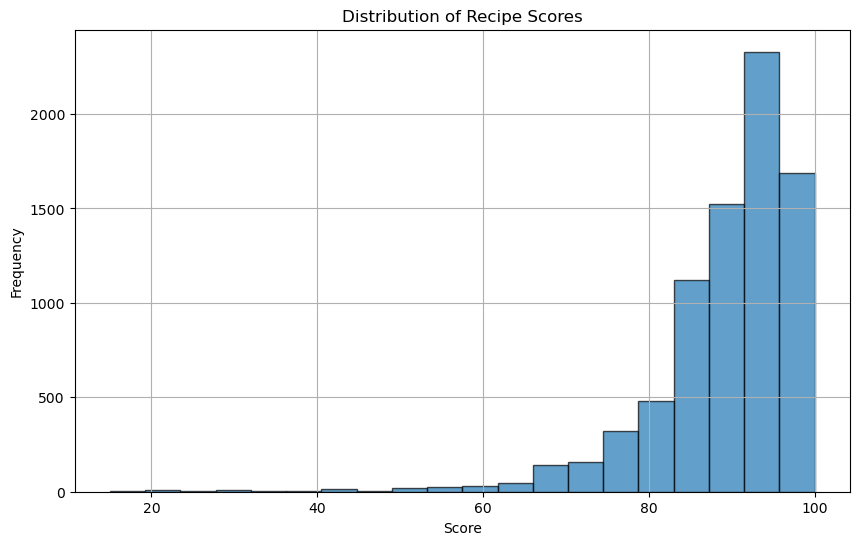

In [6]:
# Plot the distribution of the scores
plt.figure(figsize=(10, 6))
plt.hist(df_recipes['Score'].dropna(), bins=20, edgecolor='k', alpha=0.7)
plt.title('Distribution of Recipe Scores')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

The ratings of recipes tend to be rather on the positive side for throughout the dataset. 

In [7]:
# Transform the Role column
role_mapping = {
    'Tasty Team': 0,
    'Community Member': 1,
    None: 2
}
df_recipes['Role'] = df_recipes['Role'].map(lambda x: role_mapping.get(x, 2))

In [8]:
# Get the count of each role, including NaN values separately
role_counts = df_recipes['Role'].value_counts(dropna=False)
# Print the exact counts
print("Role Counts: ")
print(role_counts)

Role Counts: 
Role
0    7351
2    1771
1    1128
Name: count, dtype: int64


In [9]:
# Filter out NaN roles
filtered_df = df_recipes[df_recipes['Role'] != 2]

# Get the count of each role, excluding NaN values
role_counts_filtered = filtered_df['Role'].value_counts()

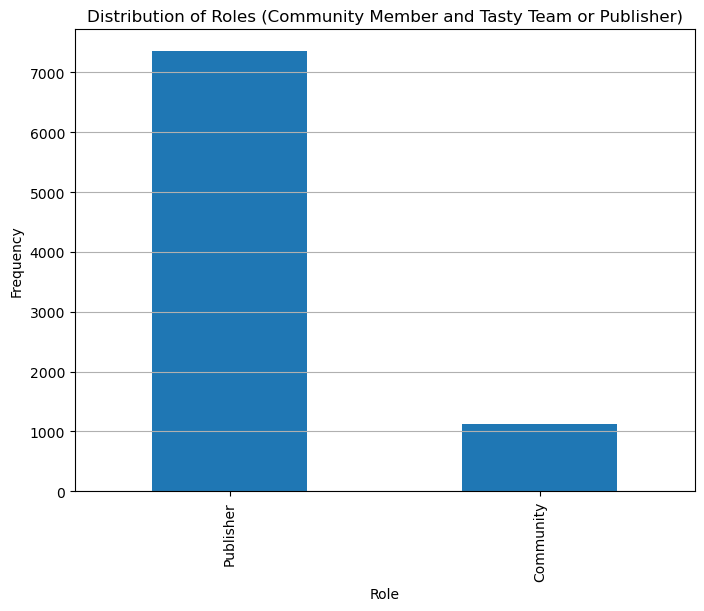

In [10]:
# Plot the distribution of the Role column excluding NaN
plt.figure(figsize=(8, 6))
role_counts_filtered.plot(kind='bar')
plt.title('Distribution of Roles (Community Member and Tasty Team or Publisher)')
plt.xlabel('Role')
plt.ylabel('Frequency')
plt.xticks(ticks=[0, 1], labels=['Publisher', 'Community'])
plt.grid(axis='y')
plt.show()

In [11]:
# Identify recipes with Role = 2
role_2_recipes = df_recipes[df_recipes['Role'] == 2]

In [12]:
# Print unique authors for recipes with Role = 2
unique_authors_with_role_2 = role_2_recipes['Author'].dropna().unique()
print("Unique Authors with Role = 2:")
print(unique_authors_with_role_2)

Unique Authors with Role = 2:
['Kroger' 'Visit Florida' 'Walmart' 'Prego' "Hellmann's" 'KraftHeinz'
 'Lipton' "Bush's Beans" 'VisitSingapore' 'Easter Sunday'
 'Starbucks Frappuccino' 'Newell Ball' 'McCormick' 'Guinness' 'Planet Oat'
 'Intuit TurboTax Live' 'LALA' "Campbell's" "Frank's RedHot" 'Pace'
 'Cabot Creamery Co-operative' 'Bumble Bee Tuna' 'Ore-Ida'
 'Amazon Prime Fresh' 'Pepsi' 'The Little Potato Company' 'Geico'
 'Tanqueray' 'SpongeTowels' 'Pillsbury' 'Heluva Good' 'Crown Royal'
 'Castle Wood Reserve' 'Napoleon' 'Captain Morgan' 'Bulleit'
 'Charter Reserve' "Welch's" 'McCain Foods' 'DoorDash' "Justin's"
 'Snyder’s of Hanover®' 'Albertsons' 'Cholula' 'Stella Rosa® Wines'
 'Grill Mates' 'Sabra' 'Deep Indian Kitchen' 'Sun-Bird' 'Juicy Juice'
 'Next Level Chef on Fox' 'Birds Eye' "French's" 'Kerrygold' 'Modelo'
 'Impossible™ Foods' 'Chase' 'Pure Leaf' 'Mezzetta' 'Biden For President'
 "BJ's Wholesale" 'Palmolive' 'Signature Select' 'Incredible Egg'
 'Country Crock® Plant Based an

Those are recipes published by official partners and will belong to non-community recipes.

In [13]:
# Debugging: Print the number of recipes with Role = 2 before updating
print(f"Number of recipes with Role = 2 before updating: {len(role_2_recipes)}")

Number of recipes with Role = 2 before updating: 1771


In [14]:
# Update Role = 2 to Role = 0 for partner recipes with identified authors
for author in unique_authors_with_role_2:
    matching_recipes = df_recipes.loc[(df_recipes['Author'] == author) & (df_recipes['Role'] == 2)]
    df_recipes.loc[(df_recipes['Author'] == author) & (df_recipes['Role'] == 2), 'Role'] = 0
    # Debugging: Print the number of recipes updated for each author
    print(f"Updated {len(matching_recipes)} recipes for author {author}")

Updated 80 recipes for author Kroger
Updated 8 recipes for author Visit Florida
Updated 43 recipes for author Walmart
Updated 10 recipes for author Prego
Updated 2 recipes for author Hellmann's
Updated 21 recipes for author KraftHeinz
Updated 4 recipes for author Lipton
Updated 12 recipes for author Bush's Beans
Updated 15 recipes for author VisitSingapore
Updated 2 recipes for author Easter Sunday
Updated 8 recipes for author Starbucks Frappuccino
Updated 12 recipes for author Newell Ball
Updated 77 recipes for author McCormick
Updated 5 recipes for author Guinness
Updated 17 recipes for author Planet Oat
Updated 2 recipes for author Intuit TurboTax Live
Updated 8 recipes for author LALA
Updated 32 recipes for author Campbell's
Updated 23 recipes for author Frank's RedHot
Updated 10 recipes for author Pace
Updated 12 recipes for author Cabot Creamery Co-operative
Updated 3 recipes for author Bumble Bee Tuna
Updated 2 recipes for author Ore-Ida
Updated 4 recipes for author Amazon Prime

In [15]:
# Debugging: Print the number of recipes with Role = 2 after updating
role_2_recipes_after = df_recipes[df_recipes['Role'] == 2]
print(f"Number of recipes with Role = 2 after updating: {len(role_2_recipes_after)}")

Number of recipes with Role = 2 after updating: 1051


In [16]:
# Get the count of each role after the update
role_counts_after = df_recipes['Role'].value_counts()

In [17]:
# Print the exact counts after the update
print("Role Counts after updating specific Role = 2 to Role = 0:")
print(role_counts_after)

Role Counts after updating specific Role = 2 to Role = 0:
Role
0    8071
1    1128
2    1051
Name: count, dtype: int64


In [18]:
# Filter out NaN roles for plotting
filtered_df_after = df_recipes[df_recipes['Role'] != 2]

# Get the count of each role, excluding NaN values
role_counts_filtered_after = filtered_df_after['Role'].value_counts()

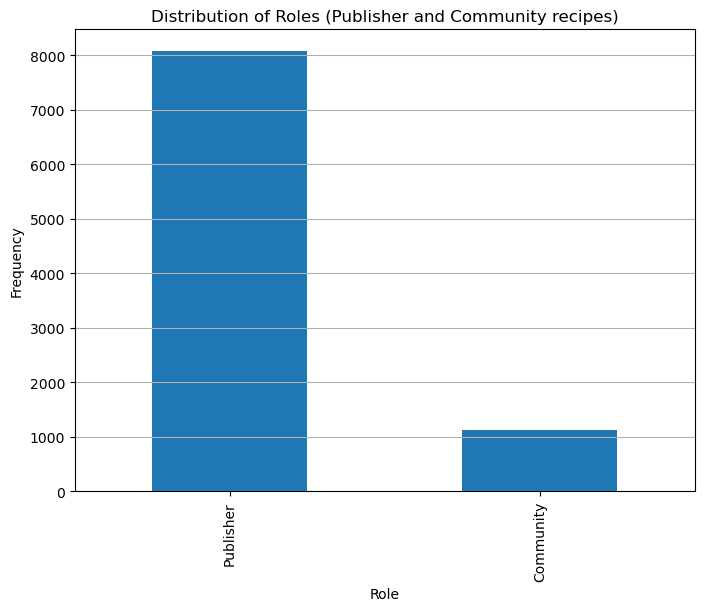

In [19]:
# Plot the distribution of the Role column excluding NaN
plt.figure(figsize=(8, 6))
role_counts_filtered_after.plot(kind='bar')
plt.title('Distribution of Roles (Publisher and Community recipes)')
plt.xlabel('Role')
plt.ylabel('Frequency')
plt.xticks(ticks=[0, 1], labels=['Publisher', 'Community'])
plt.grid(axis='y')
plt.show()

1. **Imbalance in Data**:
   - The number of publisher recipes (8071) is significantly higher than the number of community recipes (1128). This indicates an imbalance in the dataset.

2. **Publisher Recipes**:
   - These are likely to be more standardized, possibly following specific guidelines and quality checks.
   - They may have more consistent and complete data, making them potentially more reliable for training models.

3. **Community Recipes**:
   - These recipes might exhibit more variability in style, ingredients, and instructions, reflecting a wider range of cooking practices and preferences.
   - They could provide valuable diversity to the dataset, capturing a broader spectrum of culinary creativity.

4. **Separate Analysis**:
   - Given the disparity, it might be useful to analyze publisher and community recipes separately to understand unique patterns and features within each group.

6. **Feature Importance**:
   - Analyzing feature importance separately for each group might uncover different driving factors for each type of recipe, aiding in more tailored recommendations and insights.

### 2.1 Data cleaning and exploration of publisher and community data

In [20]:
# Function to convert time strings to minutes
def convert_to_minutes(time_str):
    if pd.isna(time_str):
        return None
    time_str = time_str.lower()
    minutes = 0
    if 'hr' in time_str:
        hours = re.search(r'(\d+)\s*hr', time_str)
        if hours:
            minutes += int(hours.group(1)) * 60
    if 'min' in time_str:
        mins = re.search(r'(\d+)\s*min', time_str)
        if mins:
            minutes += int(mins.group(1))
    elif 'minute' in time_str:
        mins = re.search(r'(\d+)\s*minute', time_str)
        if mins:
            minutes += int(mins.group(1))
    return minutes

# Apply the function to transform cooking times to floats
df_recipes['Total Time'] = df_recipes['Total Time'].apply(convert_to_minutes)
df_recipes['Prep Time'] = df_recipes['Prep Time'].apply(convert_to_minutes)
df_recipes['Cook Time'] = df_recipes['Cook Time'].apply(convert_to_minutes)

In [21]:
# Function to remove 'g' from nutritional values and convert to floats
def remove_g(value):
    if pd.isna(value):
        return None
    return float(value.replace('g', '').strip())

In [22]:
# Apply the function to nutritional data columns
df_recipes['Fat'] = df_recipes['Fat'].apply(lambda x: remove_g(str(x)))
df_recipes['Carbs'] = df_recipes['Carbs'].apply(lambda x: remove_g(str(x)))
df_recipes['Fiber'] = df_recipes['Fiber'].apply(lambda x: remove_g(str(x)))
df_recipes['Sugar'] = df_recipes['Sugar'].apply(lambda x: remove_g(str(x)))
df_recipes['Protein'] = df_recipes['Protein'].apply(lambda x: remove_g(str(x)))

In [23]:
# Split the data into Publisher and Community Member
publisher_recipes = df_recipes[df_recipes['Role'] == 0]
community_recipes = df_recipes[df_recipes['Role'] == 1]

# Basic statistics for each group
print("Basic Statistics for Publisher Recipes:")
print(publisher_recipes.describe())

print("\nBasic Statistics for Community Member Recipes:")
print(community_recipes.describe())

Basic Statistics for Publisher Recipes:
         Role        Score   Total Time    Prep Time    Cook Time  \
count  8071.0  6822.000000  6427.000000  6446.000000  6446.000000   
mean      0.0    88.903401    96.668430    32.262799    41.475954   
std       0.0     9.101984   134.079789    58.150367    72.266239   
min       0.0    15.000000     1.000000     1.000000     1.000000   
25%       0.0    86.000000    35.000000    15.000000    15.000000   
50%       0.0    91.000000    55.000000    20.000000    25.000000   
75%       0.0    95.000000   100.000000    30.000000    40.000000   
max       0.0   100.000000  1410.000000  1060.000000  1425.000000   

          Calories          Fat        Carbs        Fiber        Sugar  \
count  7250.000000  7250.000000  7250.000000  7250.000000  7250.000000   
mean    446.631862    21.042483    45.683862     3.943172    17.142897   
std     299.843220    18.818139    36.727966     5.397237    18.908103   
min       0.000000     0.000000     0.0000

In [24]:
# Basic Information
# Basic statistics for each group
print("Basic information for Publisher Recipes:")
print(publisher_recipes.info())

print("\nBasic information for Community Member Recipes:")
print(community_recipes.info())

Basic information for Publisher Recipes:
<class 'pandas.core.frame.DataFrame'>
Index: 8071 entries, 3 to 10249
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Recipe Title       8071 non-null   object 
 1   Author             8071 non-null   object 
 2   Role               8071 non-null   int64  
 3   Score              6822 non-null   float64
 4   Total Time         6427 non-null   float64
 5   Prep Time          6446 non-null   float64
 6   Cook Time          6446 non-null   float64
 7   Ingredients        8071 non-null   object 
 8   Preparation Steps  8071 non-null   object 
 9   Calories           7250 non-null   float64
 10  Fat                7250 non-null   float64
 11  Carbs              7250 non-null   float64
 12  Fiber              7250 non-null   float64
 13  Sugar              7250 non-null   float64
 14  Protein            7250 non-null   float64
 15  Tags               8071 non-null   

### Recipe scores

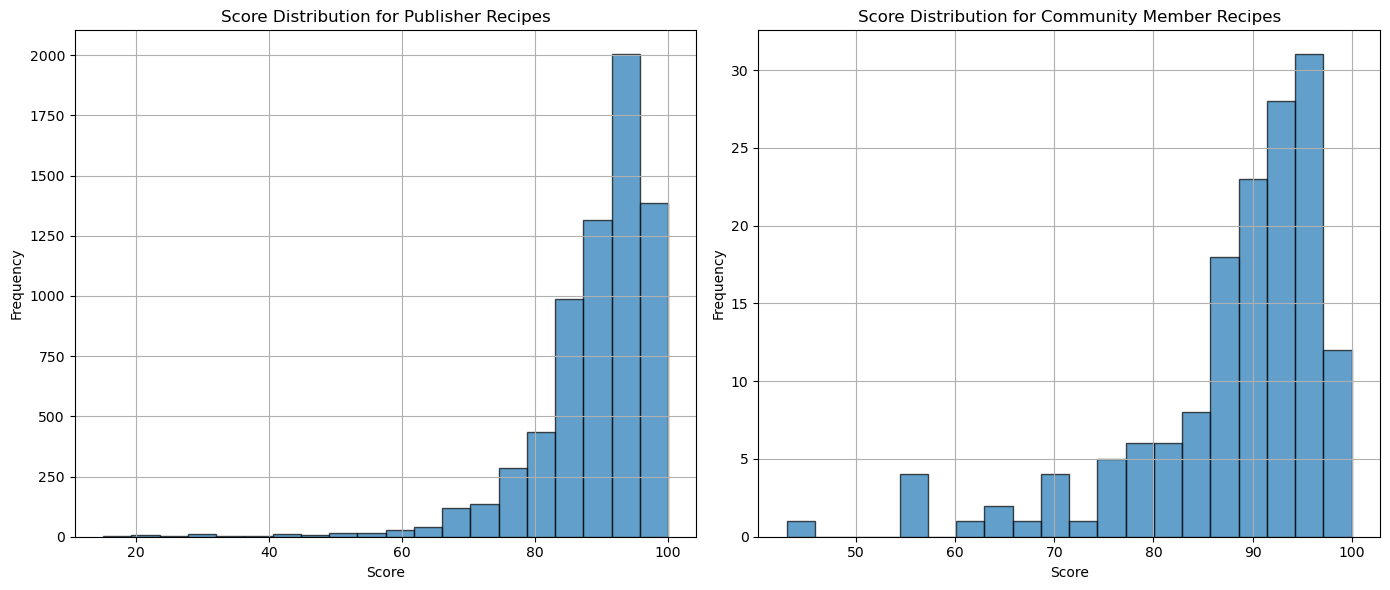

In [25]:
# Score distribution for each group
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.hist(publisher_recipes['Score'].dropna(), bins=20, edgecolor='k', alpha=0.7)
plt.title('Score Distribution for Publisher Recipes')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.hist(community_recipes['Score'].dropna(), bins=20, edgecolor='k', alpha=0.7)
plt.title('Score Distribution for Community Member Recipes')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.grid(True)

plt.tight_layout()
plt.show()

### Cooking times

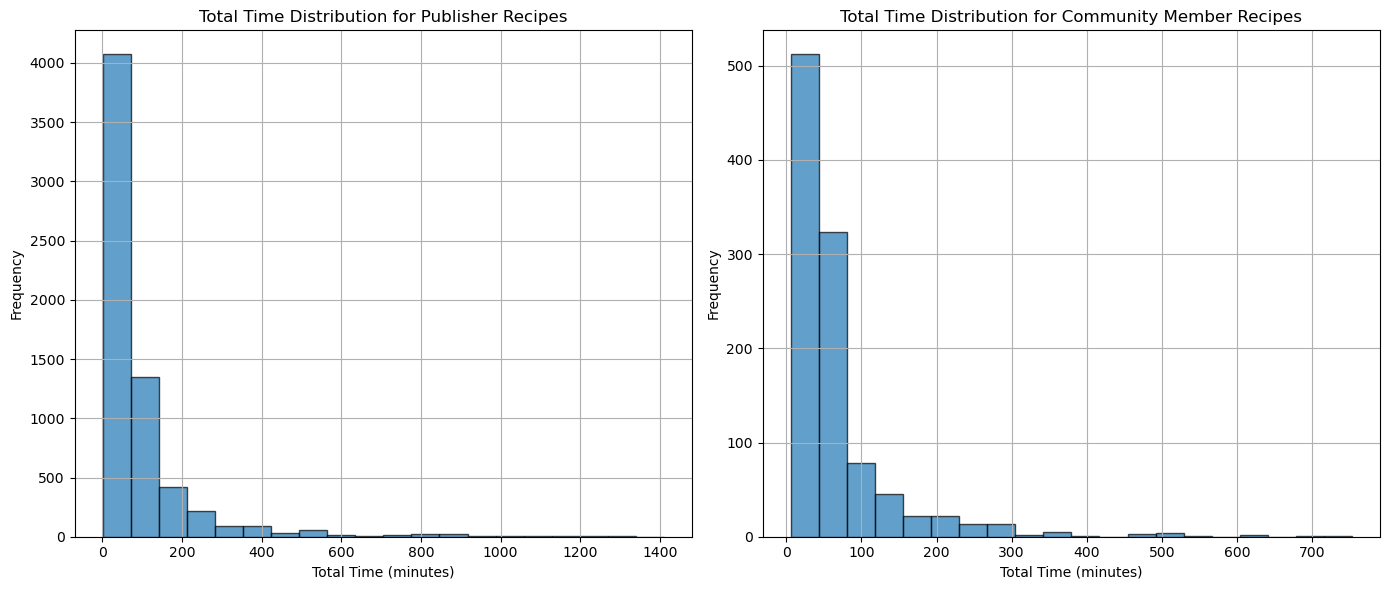

In [26]:
# Plot total time distribution for each group
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.hist(publisher_recipes['Total Time'].dropna(), bins=20, edgecolor='k', alpha=0.7)
plt.title('Total Time Distribution for Publisher Recipes')
plt.xlabel('Total Time (minutes)')
plt.ylabel('Frequency')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.hist(community_recipes['Total Time'].dropna(), bins=20, edgecolor='k', alpha=0.7)
plt.title('Total Time Distribution for Community Member Recipes')
plt.xlabel('Total Time (minutes)')
plt.ylabel('Frequency')
plt.grid(True)

plt.tight_layout()
plt.show()

### Nutritional values

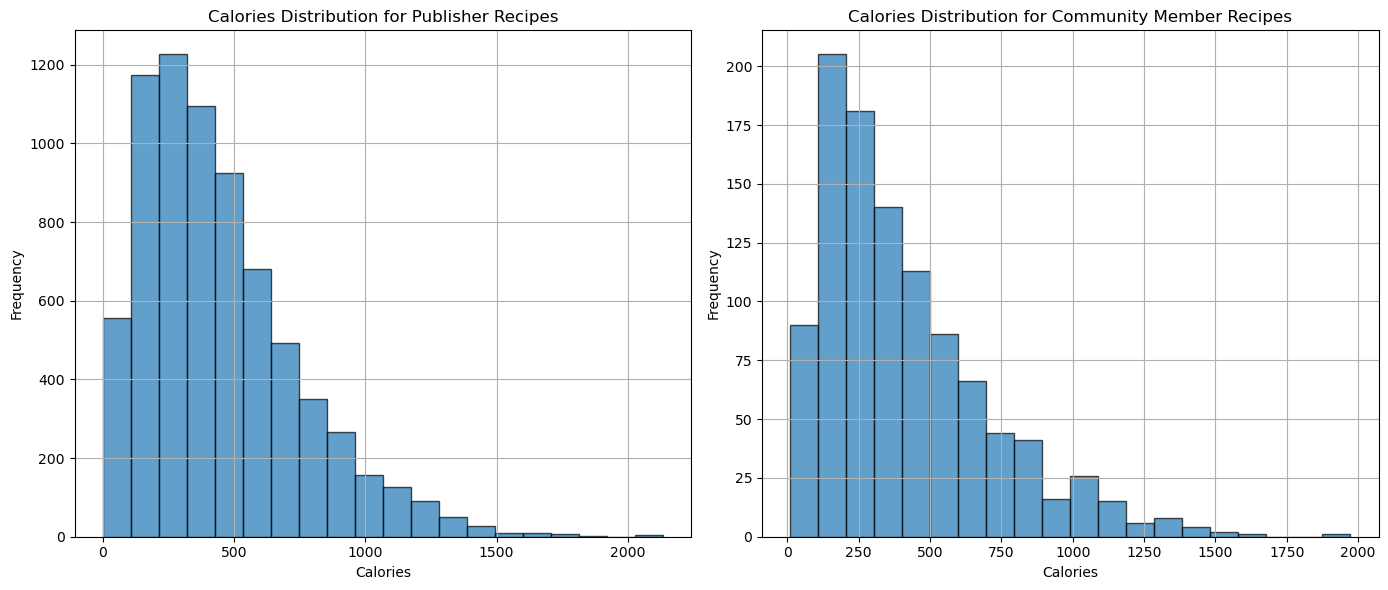

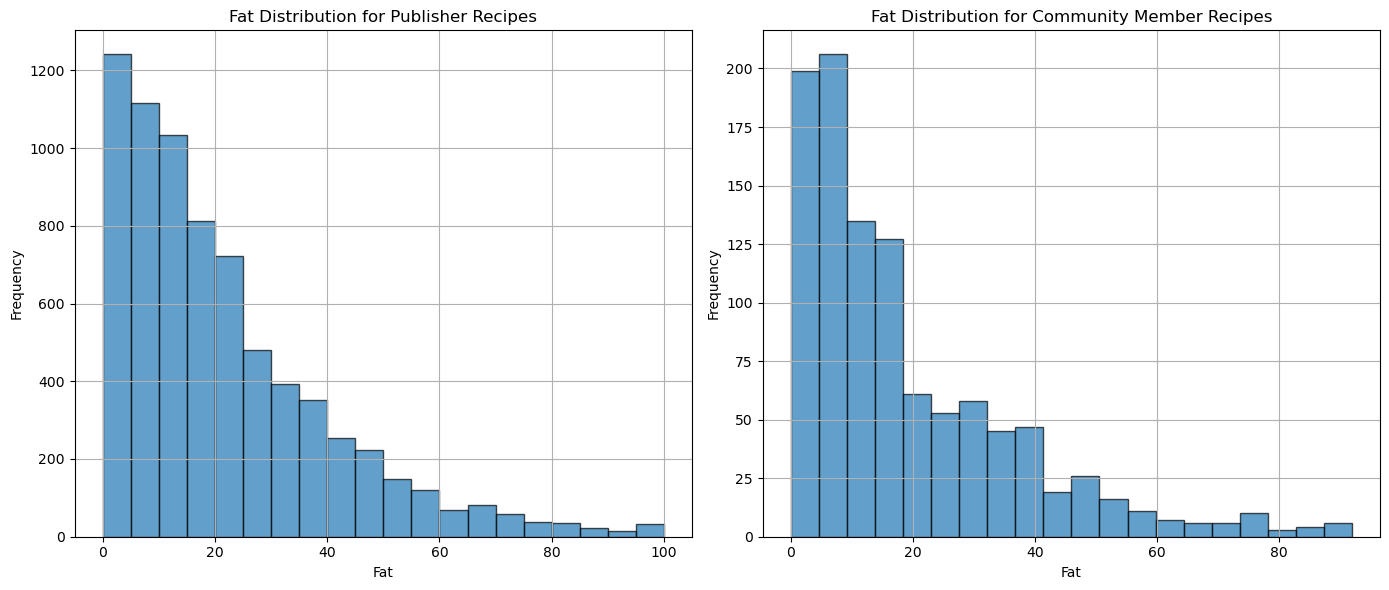

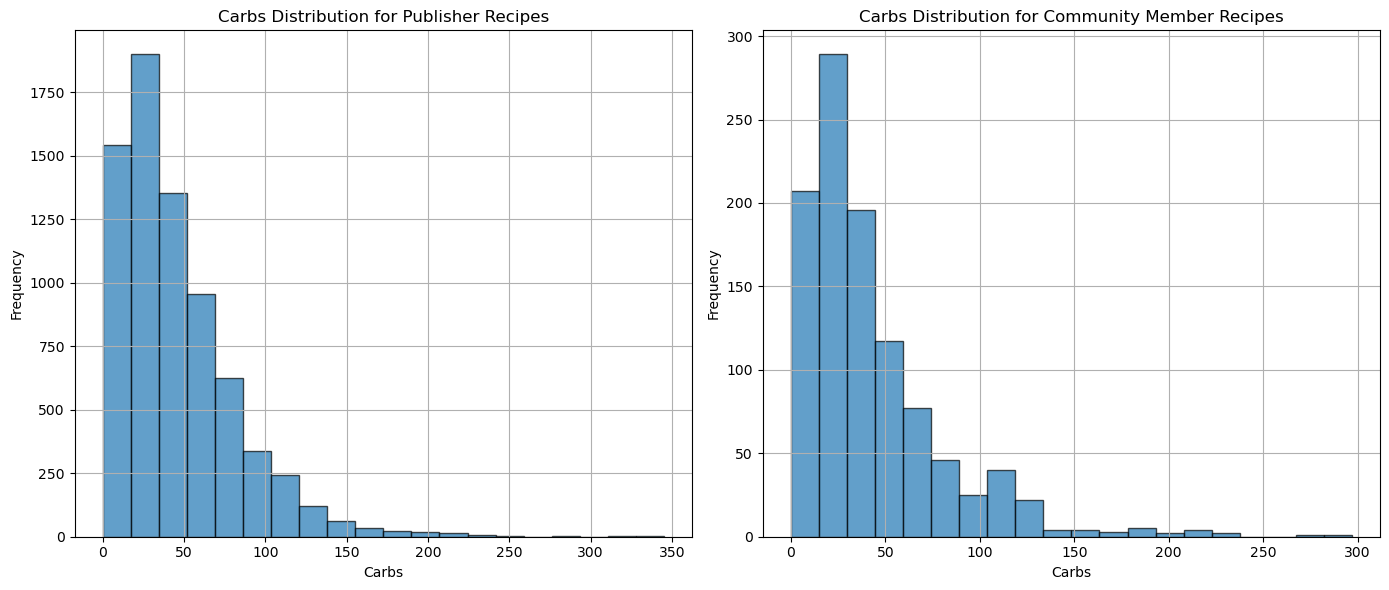

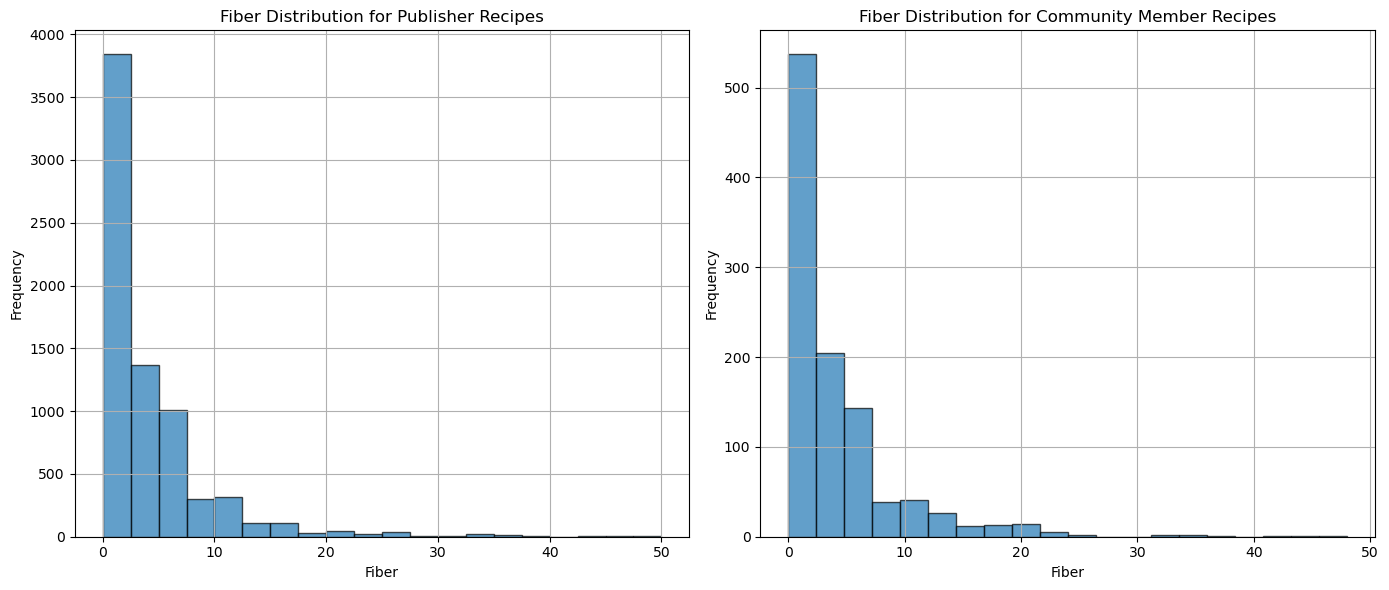

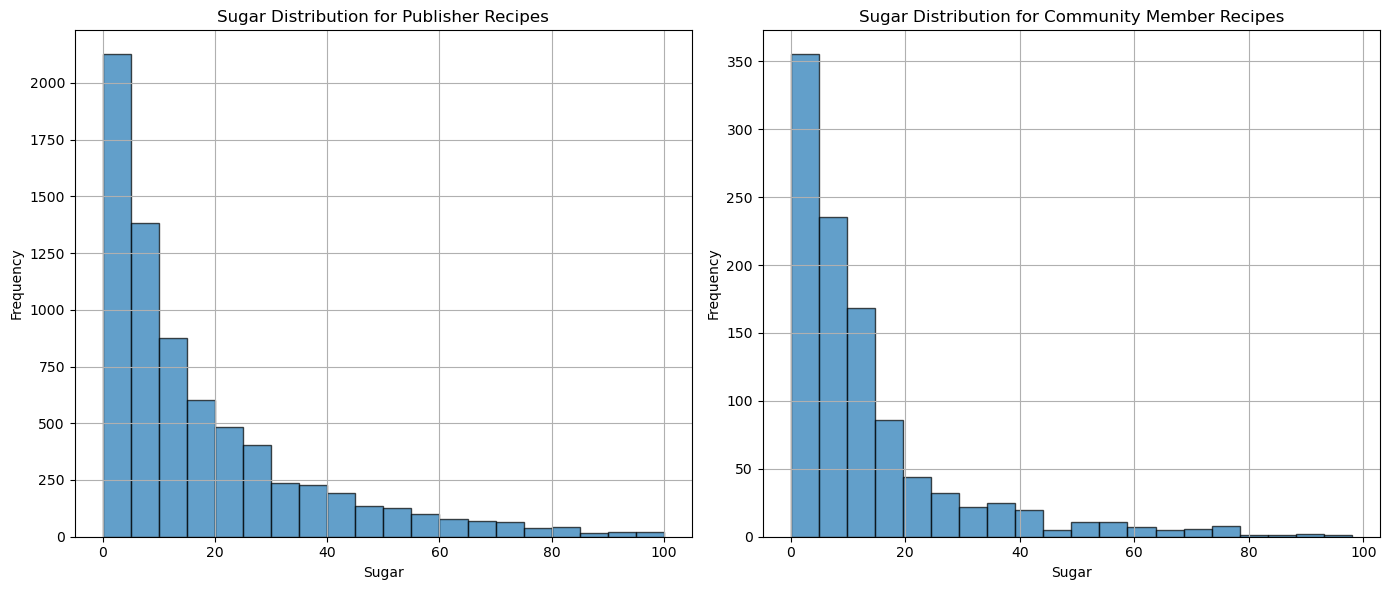

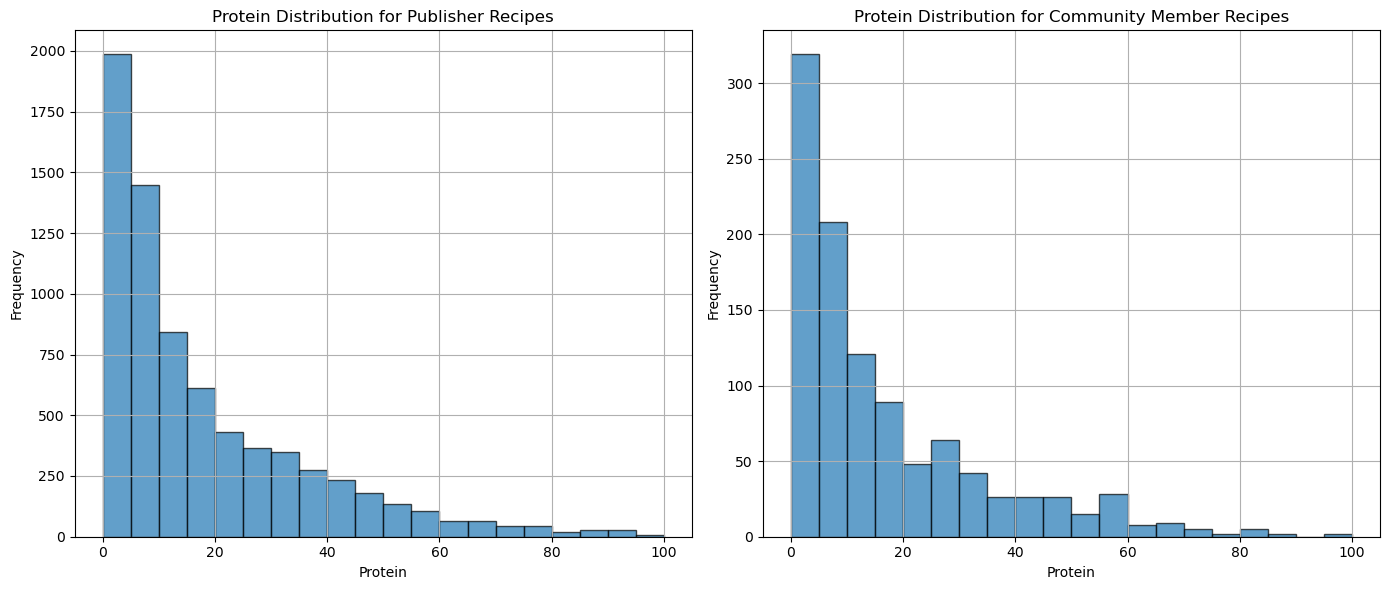

In [27]:
# Nutritional data distribution for each group
nutritional_columns = ['Calories', 'Fat', 'Carbs', 'Fiber', 'Sugar', 'Protein']
for col in nutritional_columns:
    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    plt.hist(publisher_recipes[col].dropna(), bins=20, edgecolor='k', alpha=0.7)
    plt.title(f'{col} Distribution for Publisher Recipes')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.hist(community_recipes[col].dropna(), bins=20, edgecolor='k', alpha=0.7)
    plt.title(f'{col} Distribution for Community Member Recipes')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

### Observations

**Scores:** Both Publishers and Community Members have similar average scores, indicating a similar level of satisfaction among users.

**Cooking Times:** Publisher recipes tend to have higher average total and cook times compared to Community Member recipes, suggesting they might be more complex or elaborate.

**Nutritional Data:**

Calories and Nutrients: Publisher recipes have slightly higher average calories and nutrients like fat, carbs, and protein, which might indicate richer or more indulgent recipes.

In [28]:
# List of common spices and ingredients to exclude
exclude_patterns = [
    r'salt', r'pepper', r'olive oil', r'water', r'sugar', r'garlic', 
    r'onion', r'butter', r'oil', r'vanilla', r'spray', r'soy',
    r'baking soda', r'flour', r'milk', r'egg', r'eggs', r'paprika', r'juice', r'powder', r'seeds', r'oregano', r'cornstarch', r'leaves'
]

In [29]:
# Function to normalize ingredient names by removing amounts and units
def normalize_ingredient(ingredient):
    # Remove common fractions
    ingredient = re.sub(r'\b(½|¼|¾|⅓|⅔)\b', '', ingredient)
    # Remove standalone numbers and fractions
    ingredient = re.sub(r'\d+\s*/\s*\d+', '', ingredient)  # Remove fractions
    ingredient = re.sub(r'\d+', '', ingredient)  # Remove standalone numbers
    # Remove units
    ingredient = re.sub(r'\b(cup|cups|tablespoon|tablespoons|teaspoon|teaspoons|oz|ounce|ounces|lb|pound|pounds|g|grams|kg|kilograms|ml|milliliters|liter|liters)\b', '', ingredient, flags=re.IGNORECASE)
    # Remove text in parentheses
    ingredient = re.sub(r'\([^)]*\)', '', ingredient)
    # Remove punctuation
    ingredient = re.sub(r'[^\w\s]', '', ingredient)
    # Remove extra whitespace
    ingredient = ' '.join(ingredient.split())
    ingredient = ingredient.strip().lower()
    return ingredient

In [30]:
# Function to process ingredient lists and count frequency of each ingredient
def count_ingredients(recipes, exclude_patterns):
    all_ingredients = []
    for ingredients_list in recipes['Ingredients'].dropna():
        ingredients = eval(ingredients_list)  # Convert string representation of list to actual list
        normalized_ingredients = [normalize_ingredient(ingredient) for ingredient in ingredients]
        filtered_ingredients = [ingredient for ingredient in normalized_ingredients if not any(re.search(pattern, ingredient) for pattern in exclude_patterns)]
        all_ingredients.extend(filtered_ingredients)
    return Counter(all_ingredients)

In [31]:
# Count ingredients for each group
publisher_ingredients_count = count_ingredients(publisher_recipes, exclude_patterns)
community_ingredients_count = count_ingredients(community_recipes, exclude_patterns)

# Get the most common ingredients
most_common_publisher_ingredients = publisher_ingredients_count.most_common(20)
most_common_community_ingredients = community_ingredients_count.most_common(20)

In [32]:
# Print the most common ingredients
print("Most Common Ingredients in Publisher Recipes:")
for ingredient, count in most_common_publisher_ingredients:
    print(f"{ingredient}: {count}")

print("\nMost Common Ingredients in Community Member Recipes:")
for ingredient, count in most_common_community_ingredients:
    print(f"{ingredient}: {count}")

Most Common Ingredients in Publisher Recipes:
honey: 633
heavy cream: 522
cinnamon: 372
maple syrup: 310
shredded mozzarella cheese: 304
mayonnaise: 302
ground cinnamon: 302
ground cumin: 287
sour cream: 278
shredded cheddar cheese: 277
grated parmesan cheese: 244
apple cider vinegar: 240
dijon mustard: 225
cumin: 219
ground beef: 219
fresh parsley chopped: 185
cream cheese softened: 184
tomato paste: 162
greek yogurt: 161
cream cheese: 155

Most Common Ingredients in Community Member Recipes:
cinnamon: 72
cumin: 57
turmeric: 50
chocolate chips: 42
honey: 39
heavy cream: 34
maple syrup: 30
sour cream: 30
garam masala: 29
mayonnaise: 26
fresh parsley: 25
heavy whipping cream: 25
chicken broth: 23
ground beef: 23
nutmeg: 23
lemon: 22
oats: 22
tomato paste: 20
ground cinnamon: 20
coriander: 19


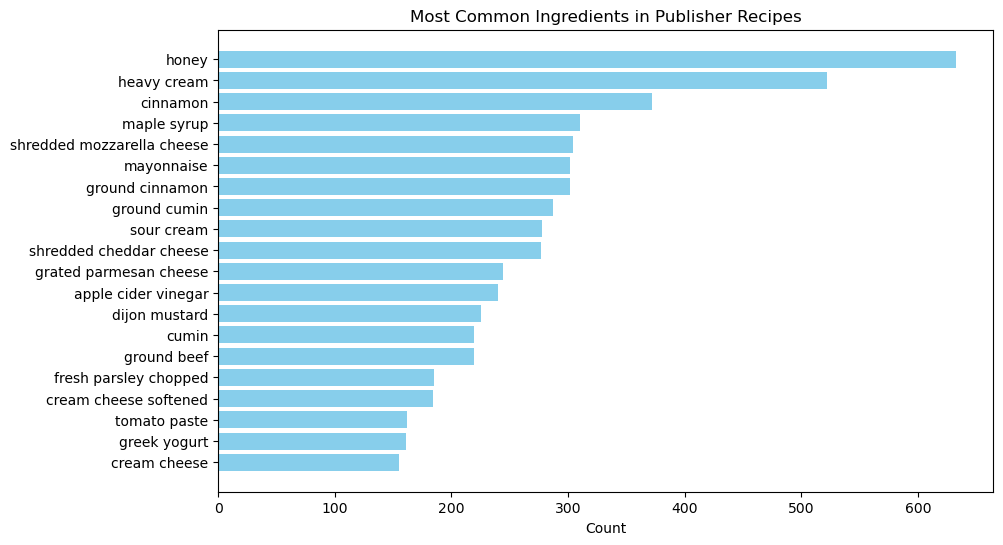

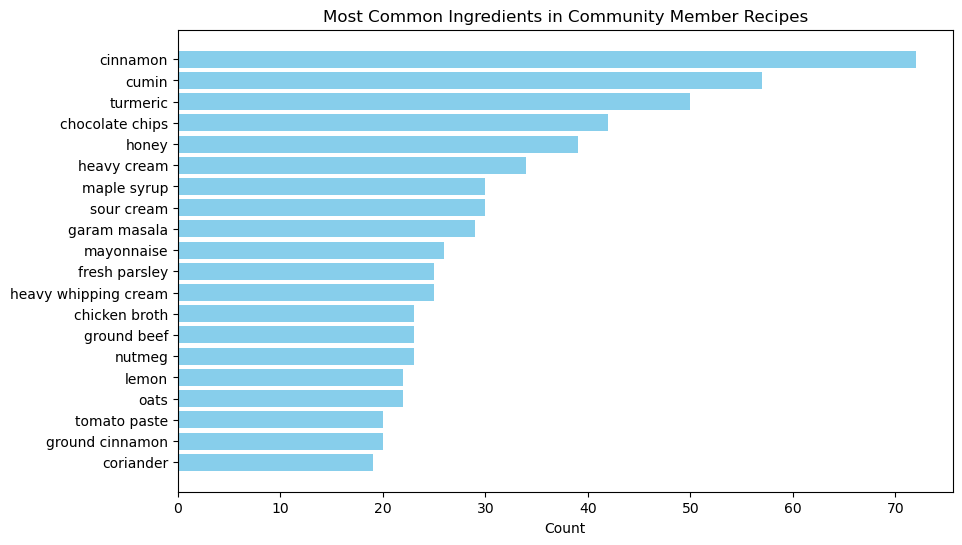

In [33]:
# Plot the most common ingredients for each group
def plot_common_ingredients(common_ingredients, title):
    ingredients, counts = zip(*common_ingredients)
    plt.figure(figsize=(10, 6))
    plt.barh(ingredients, counts, color='skyblue')
    plt.xlabel('Count')
    plt.title(title)
    plt.gca().invert_yaxis()
    plt.show()

# Plot the most common ingredients for Publisher and Community Member recipes
plot_common_ingredients(most_common_publisher_ingredients, 'Most Common Ingredients in Publisher Recipes')
plot_common_ingredients(most_common_community_ingredients, 'Most Common Ingredients in Community Member Recipes')

**Learnings:**

**Sweeteners and Dairy:** Both groups frequently use honey, heavy cream, and sour cream.

**Spices:** Cinnamon, cumin, and turmeric are common in both groups, reflecting their versatility.

**Community Recipes:** Show a greater variety of spices and specific ingredients like garam masala and coriander, indicating diverse culinary influences.

**Publisher Recipes:** Tend to use more dairy products and standard American condiments like mayonnaise and Dijon mustard.

### Number of steps and ingredients

In [34]:
# Function to count the number of steps in the preparation steps
def count_steps(preparation_steps):
    try:
        steps = eval(preparation_steps)
        return len(steps)
    except:
        return 0

# Function to count the number of ingredients
def count_ingredients(ingredients):
    try:
        ingredients_list = eval(ingredients)
        return len(ingredients_list)
    except:
        return 0

In [35]:
# Add new columns for the number of steps and the number of ingredients
df_recipes['Number of Steps'] = df_recipes['Preparation Steps'].apply(count_steps)
df_recipes['Number of Ingredients'] = df_recipes['Ingredients'].apply(count_ingredients)

In [36]:
# Split the data into Publisher and Community Member recipes
publisher_recipes = df_recipes[df_recipes['Role'] == 0]
community_recipes = df_recipes[df_recipes['Role'] == 1]

# Calculate basic statistics for the number of steps and number of ingredients
publisher_stats = publisher_recipes[['Number of Steps', 'Number of Ingredients']].describe()
community_stats = community_recipes[['Number of Steps', 'Number of Ingredients']].describe()

# Print the statistics
print("Publisher Recipes Statistics:")
print(publisher_stats)
print("\nCommunity Member Recipes Statistics:")
print(community_stats)

Publisher Recipes Statistics:
       Number of Steps  Number of Ingredients
count      8071.000000            8071.000000
mean          9.569694              12.006691
std           3.854583               6.408672
min           2.000000               1.000000
25%           7.000000               7.000000
50%           9.000000              11.000000
75%          12.000000              16.000000
max          36.000000              61.000000

Community Member Recipes Statistics:
       Number of Steps  Number of Ingredients
count      1128.000000            1128.000000
mean          7.856383              11.311170
std           3.113176               5.092035
min           3.000000               2.000000
25%           6.000000               8.000000
50%           7.000000              11.000000
75%           9.000000              14.000000
max          25.000000              36.000000


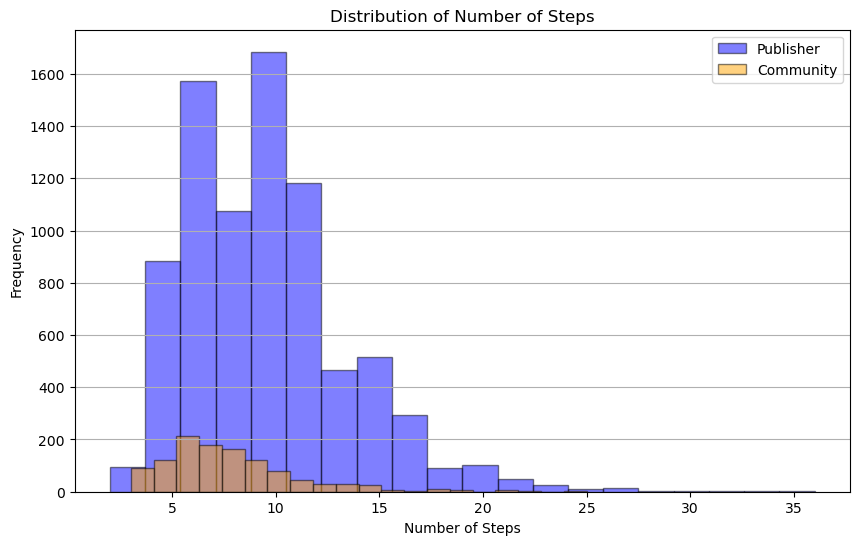

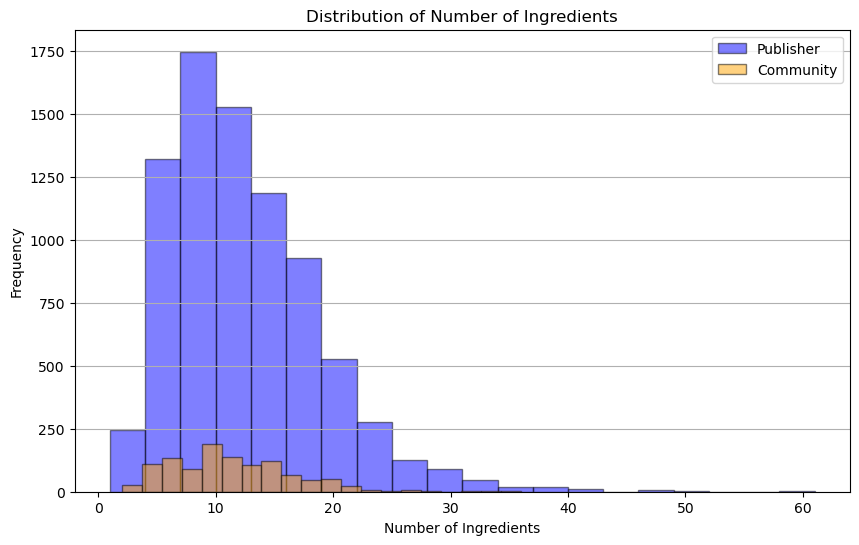

In [37]:
def plot_distribution(data, column, title):
    plt.figure(figsize=(10, 6))
    plt.hist(data[column], bins=20, alpha=0.5, label='Publisher', color='blue', edgecolor='black')
    plt.hist(community_recipes[column], bins=20, alpha=0.5, label='Community', color='orange', edgecolor='black')
    plt.title(title)
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(axis='y')
    plt.show()

# Plot distributions
plot_distribution(publisher_recipes, 'Number of Steps', 'Distribution of Number of Steps')
plot_distribution(publisher_recipes, 'Number of Ingredients', 'Distribution of Number of Ingredients')

### Comparison:

1. **Distribution of Number of Steps**:
   - Publisher recipes show a broader distribution with a higher peak at around 8-10 steps.
   - Community member recipes have a narrower distribution, with a peak at around 6-8 steps.

2. **Distribution of Number of Ingredients**:
   - Publisher recipes use a higher number of ingredients on average, with a peak around 10-12 ingredients.
   - Community member recipes have a similar peak but with a slightly lower average number of ingredients. 

These visualizations highlight the general complexity and ingredient richness of publisher recipes compared to the more straightforward and ingredient-efficient community member recipes.

### Tags

In [38]:
# Function to count tags
def count_tags(recipes):
    all_tags = []
    for tags_list in recipes['Tags'].dropna():
        tags = tags_list.split(',')
        tags = [tag.strip().lower() for tag in tags]
        all_tags.extend(tags)
    return Counter(all_tags)

# Count tags for each group
publisher_tags_count = count_tags(publisher_recipes)
community_tags_count = count_tags(community_recipes)

In [39]:
# Get the most common tags
most_common_publisher_tags = publisher_tags_count.most_common(10)
most_common_community_tags = community_tags_count.most_common(10)

In [40]:
# Print the most common tags
print("Most Common Tags in Publisher Recipes:")
for tag, count in most_common_publisher_tags:
    print(f"{tag}: {count}")

print("\nMost Common Tags in Community Member Recipes:")
for tag, count in most_common_community_tags:
    print(f"{tag}: {count}")

Most Common Tags in Publisher Recipes:
'under 1 hour': 5783
'dairy': 5568
'easy': 5225
'high-fiber': 4831
'gluten': 4778
'kid-friendly': 4759
'special occasion': 4611
'dinner': 4576
'budget': 4494
'high-protein': 4411

Most Common Tags in Community Member Recipes:
'under 1 hour': 1014
'budget': 783
'dairy': 743
'high-fiber': 705
'under 45 minutes': 704
'easy': 698
'dinner': 672
'special occasion': 665
'high-protein': 652
'vegetarian': 613


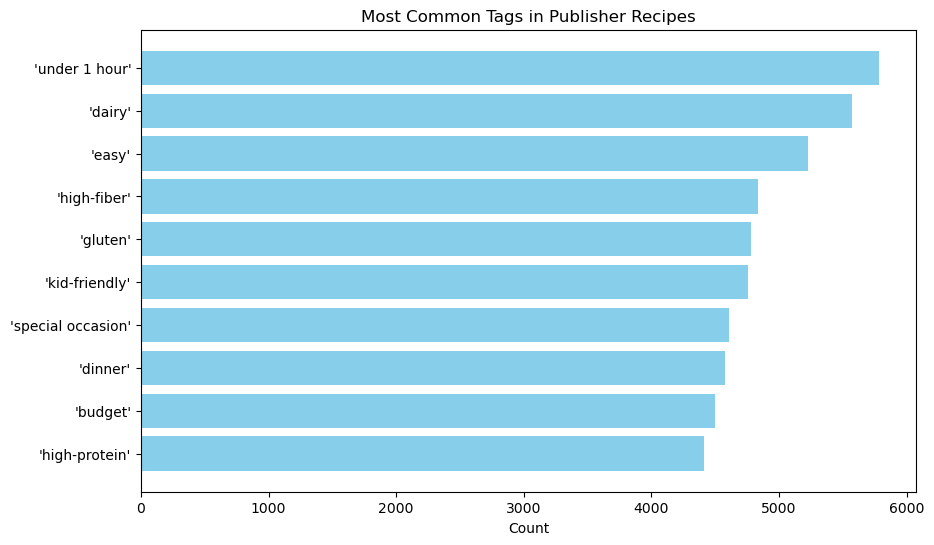

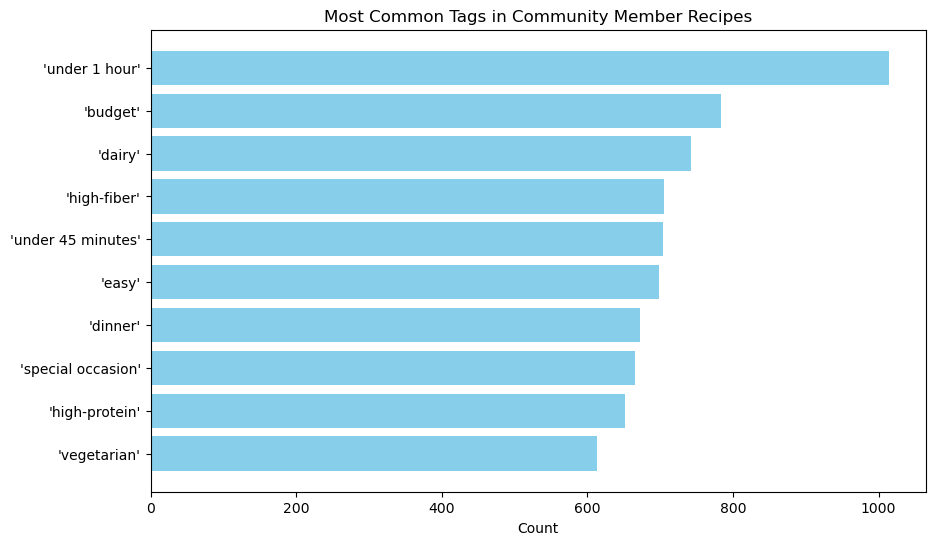

In [41]:
# Plot the most common tags for each group
def plot_common_tags(common_tags, title):
    tags, counts = zip(*common_tags)
    plt.figure(figsize=(10, 6))
    plt.barh(tags, counts, color='skyblue')
    plt.xlabel('Count')
    plt.title(title)
    plt.gca().invert_yaxis()
    plt.show()

    # Plot the most common tags for Publisher and Community Member recipes
plot_common_tags(most_common_publisher_tags, 'Most Common Tags in Publisher Recipes')
plot_common_tags(most_common_community_tags, 'Most Common Tags in Community Member Recipes')

### Comparison:
- **Commonalities**: Both publisher and community recipes prioritize quick, easy, and budget-friendly options, with a significant focus on dinner and special occasions.
- **Differences**: Publisher recipes show a broader range of dietary tags (e.g., 'kid-friendly'), while community member recipes emphasize tags like 'vegetarian' more.

These insights suggest that publisher recipes cater to a wide audience with varied dietary needs and event-specific meals, whereas community member recipes focus more on practical, time-efficient, and budget-friendly options.

## 3. Data preparation

### Removing columns

Drop Unnecessary Columns 

In [42]:
# Drop the 'Author' and 'Recipe URL' columns
df_recipes = df_recipes.drop(columns=['Author', 'Recipe URL'])

# Display the first few rows to confirm the columns are dropped
df_recipes

,Recipe Title,Role,Score,Total Time,Prep Time,Cook Time,Ingredients,Preparation Steps,Calories,Fat,Carbs,Fiber,Sugar,Protein,Tags,Number of Steps,Number of Ingredients
0,Roasted Moroccan Carrots With Baba Ganoush,1,NaN,30.0,10.0,20.0,"['1 bunch dutch carrots, washed and tops trimm...",['Place carrots on a baking dish lined with ba...,72.0,4.0,8.0,2.0,2.0,2.0,"['Meal', 'Dinner', 'Weeknight', 'Kosher', 'Hal...",4,8
1,Edamame Truffle Dumplings In Miso Broth,1,NaN,70.0,40.0,30.0,"['1 package frozen shelled edamame', '2 tables...",['Cook the frozen edamame according the packag...,413.0,16.0,49.0,6.0,3.0,18.0,"['Cuisine', 'Asian', 'Japanese', 'Soy', 'Glute...",11,19
2,Grilled Napa Cabbage Fattoush Salad,1,NaN,40.0,20.0,20.0,"['1 head medium napa cabbage', '1 small red on...",['Preheat the grill and preheat the oven to 37...,430.0,29.0,32.0,2.0,6.0,9.0,"['Cuisine', 'European', 'Mediterranean', 'Kosh...",9,20
3,Roasted Tomato Basil Soup,0,91.0,25.0,5.0,20.0,"['1 tablespoon olive oil', '1 yellow onion, di...","['In a large pot over medium heat, combine the...",48.0,0.0,9.0,1.0,2.0,1.0,"['Meal', 'Dinner', 'Soups', 'Budget', 'High-Fi...",6,13
4,Tuna Salad With Roasted Veggies,0,96.0,35.0,15.0,20.0,"['1 cup green beans (360 g), trimmed', '2 cups...","['Preheat the oven to 375˚F (190˚C).', 'On a b...",576.0,19.0,51.0,7.0,11.0,49.0,"['Meal', 'Lunch', 'Salads', 'Dairy', 'Fish', '...",10,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10245,15-Minute Donuts,0,87.0,15.0,7.0,8.0,"['8 cups canola oil (1.9 L), for frying', '4 t...",['Fill a large pot with 2 inches (5 cm) of can...,490.0,35.0,40.0,1.0,26.0,2.0,"['Cooking Style', 'Deep-Fry', 'Budget', 'Glute...",6,7
10246,Vegan Tzatziki,0,97.0,NaN,NaN,NaN,"['12 oz coconut yogurt (340 g)', '1 lemon, jui...","['In a blender or food processor, combine coco...",141.0,7.0,16.0,0.0,11.0,4.0,"['Cuisine', 'European', 'Mediterranean', 'Budg...",9,9
10247,Swiss Roll Pops,2,71.0,32.0,20.0,12.0,"['⅔ cup caster sugar (125 g), plus more for du...","['Pre-heat the oven to 200°C (400°F).', 'Add t...",150.0,3.0,25.0,0.0,16.0,2.0,"['Meal', 'Desserts', 'Cakes', 'Budget', 'Sweet...",13,7
10248,Banana Bread Cake Truffles,0,94.0,135.0,30.0,50.0,"['nonstick cooking spray, for greasing', '3 ri...",['Make the banana bread: Preheat the oven to 3...,315.0,7.0,62.0,4.0,40.0,3.0,"['Seasonal', 'Occasion', 'Party', 'Budget', 'D...",13,16


### Flatten ingredients, instructions and tags lists

In [43]:
# Define the function to flatten ingredients
def flatten_ingredients(ingredients_list):
    if isinstance(ingredients_list, str):
        ingredients_list = eval(ingredients_list)
    if isinstance(ingredients_list, list):
        flattened = [ingredient for ingredient in ingredients_list]
        return '; '.join(flattened)
    return ''

# Define the function to flatten instructions
def flatten_instructions(instructions_list):
    if isinstance(instructions_list, str):
        instructions_list = eval(instructions_list)
    if isinstance(instructions_list, list):
        steps = [instruction for instruction in instructions_list]
        return ' '.join(steps)
    return ''

# Define the function to flatten tags
def flatten_tags(tags_list):
    if isinstance(tags_list, str):
        tags_list = eval(tags_list)
    if isinstance(tags_list, list):
        flattened = [tag for tag in tags_list]
        return '; '.join(flattened)
    return ''

# Apply the functions to the DataFrame
df_recipes['Ingredients'] = df_recipes['Ingredients'].apply(flatten_ingredients)
df_recipes['Preparation Steps'] = df_recipes['Preparation Steps'].apply(flatten_instructions)
df_recipes['Tags'] = df_recipes['Tags'].apply(flatten_tags)

In [44]:
df_recipes

,Recipe Title,Role,Score,Total Time,Prep Time,Cook Time,Ingredients,Preparation Steps,Calories,Fat,Carbs,Fiber,Sugar,Protein,Tags,Number of Steps,Number of Ingredients
0,Roasted Moroccan Carrots With Baba Ganoush,1,NaN,30.0,10.0,20.0,"1 bunch dutch carrots, washed and tops trimmed...",Place carrots on a baking dish lined with baki...,72.0,4.0,8.0,2.0,2.0,2.0,Meal; Dinner; Weeknight; Kosher; Halal; Budget...,4,8
1,Edamame Truffle Dumplings In Miso Broth,1,NaN,70.0,40.0,30.0,1 package frozen shelled edamame; 2 tablespoon...,Cook the frozen edamame according the package ...,413.0,16.0,49.0,6.0,3.0,18.0,Cuisine; Asian; Japanese; Soy; Gluten; Allerge...,11,19
2,Grilled Napa Cabbage Fattoush Salad,1,NaN,40.0,20.0,20.0,"1 head medium napa cabbage; 1 small red onion,...",Preheat the grill and preheat the oven to 375°...,430.0,29.0,32.0,2.0,6.0,9.0,Cuisine; European; Mediterranean; Kosher; Dair...,9,20
3,Roasted Tomato Basil Soup,0,91.0,25.0,5.0,20.0,"1 tablespoon olive oil; 1 yellow onion, diced;...","In a large pot over medium heat, combine the o...",48.0,0.0,9.0,1.0,2.0,1.0,Meal; Dinner; Soups; Budget; High-Fiber; Low-F...,6,13
4,Tuna Salad With Roasted Veggies,0,96.0,35.0,15.0,20.0,"1 cup green beans (360 g), trimmed; 2 cups bab...",Preheat the oven to 375˚F (190˚C). On a baking...,576.0,19.0,51.0,7.0,11.0,49.0,Meal; Lunch; Salads; Dairy; Fish; European; Di...,10,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10245,15-Minute Donuts,0,87.0,15.0,7.0,8.0,"8 cups canola oil (1.9 L), for frying; 4 table...",Fill a large pot with 2 inches (5 cm) of canol...,490.0,35.0,40.0,1.0,26.0,2.0,Cooking Style; Deep-Fry; Budget; Gluten; Under...,6,7
10246,Vegan Tzatziki,0,97.0,NaN,NaN,NaN,"12 oz coconut yogurt (340 g); 1 lemon, juiced;...","In a blender or food processor, combine coconu...",141.0,7.0,16.0,0.0,11.0,4.0,Cuisine; European; Mediterranean; Budget; Dips...,9,9
10247,Swiss Roll Pops,2,71.0,32.0,20.0,12.0,"⅔ cup caster sugar (125 g), plus more for dust...",Pre-heat the oven to 200°C (400°F). Add the su...,150.0,3.0,25.0,0.0,16.0,2.0,Meal; Desserts; Cakes; Budget; Sweet Breakfast...,13,7
10248,Banana Bread Cake Truffles,0,94.0,135.0,30.0,50.0,"nonstick cooking spray, for greasing; 3 ripe b...",Make the banana bread: Preheat the oven to 350...,315.0,7.0,62.0,4.0,40.0,3.0,Seasonal; Occasion; Party; Budget; Dairy; Glut...,13,16


### Handle outliers

Outliers can significantly affect the performance of machine learning models. Many algorithms, particularly those based on distance metrics (e.g., K-Nearest Neighbors, Support Vector Machines) and linear models (e.g., Linear Regression, Logistic Regression), are sensitive to outliers. These algorithms can produce biased or skewed results when trained on data containing outliers.

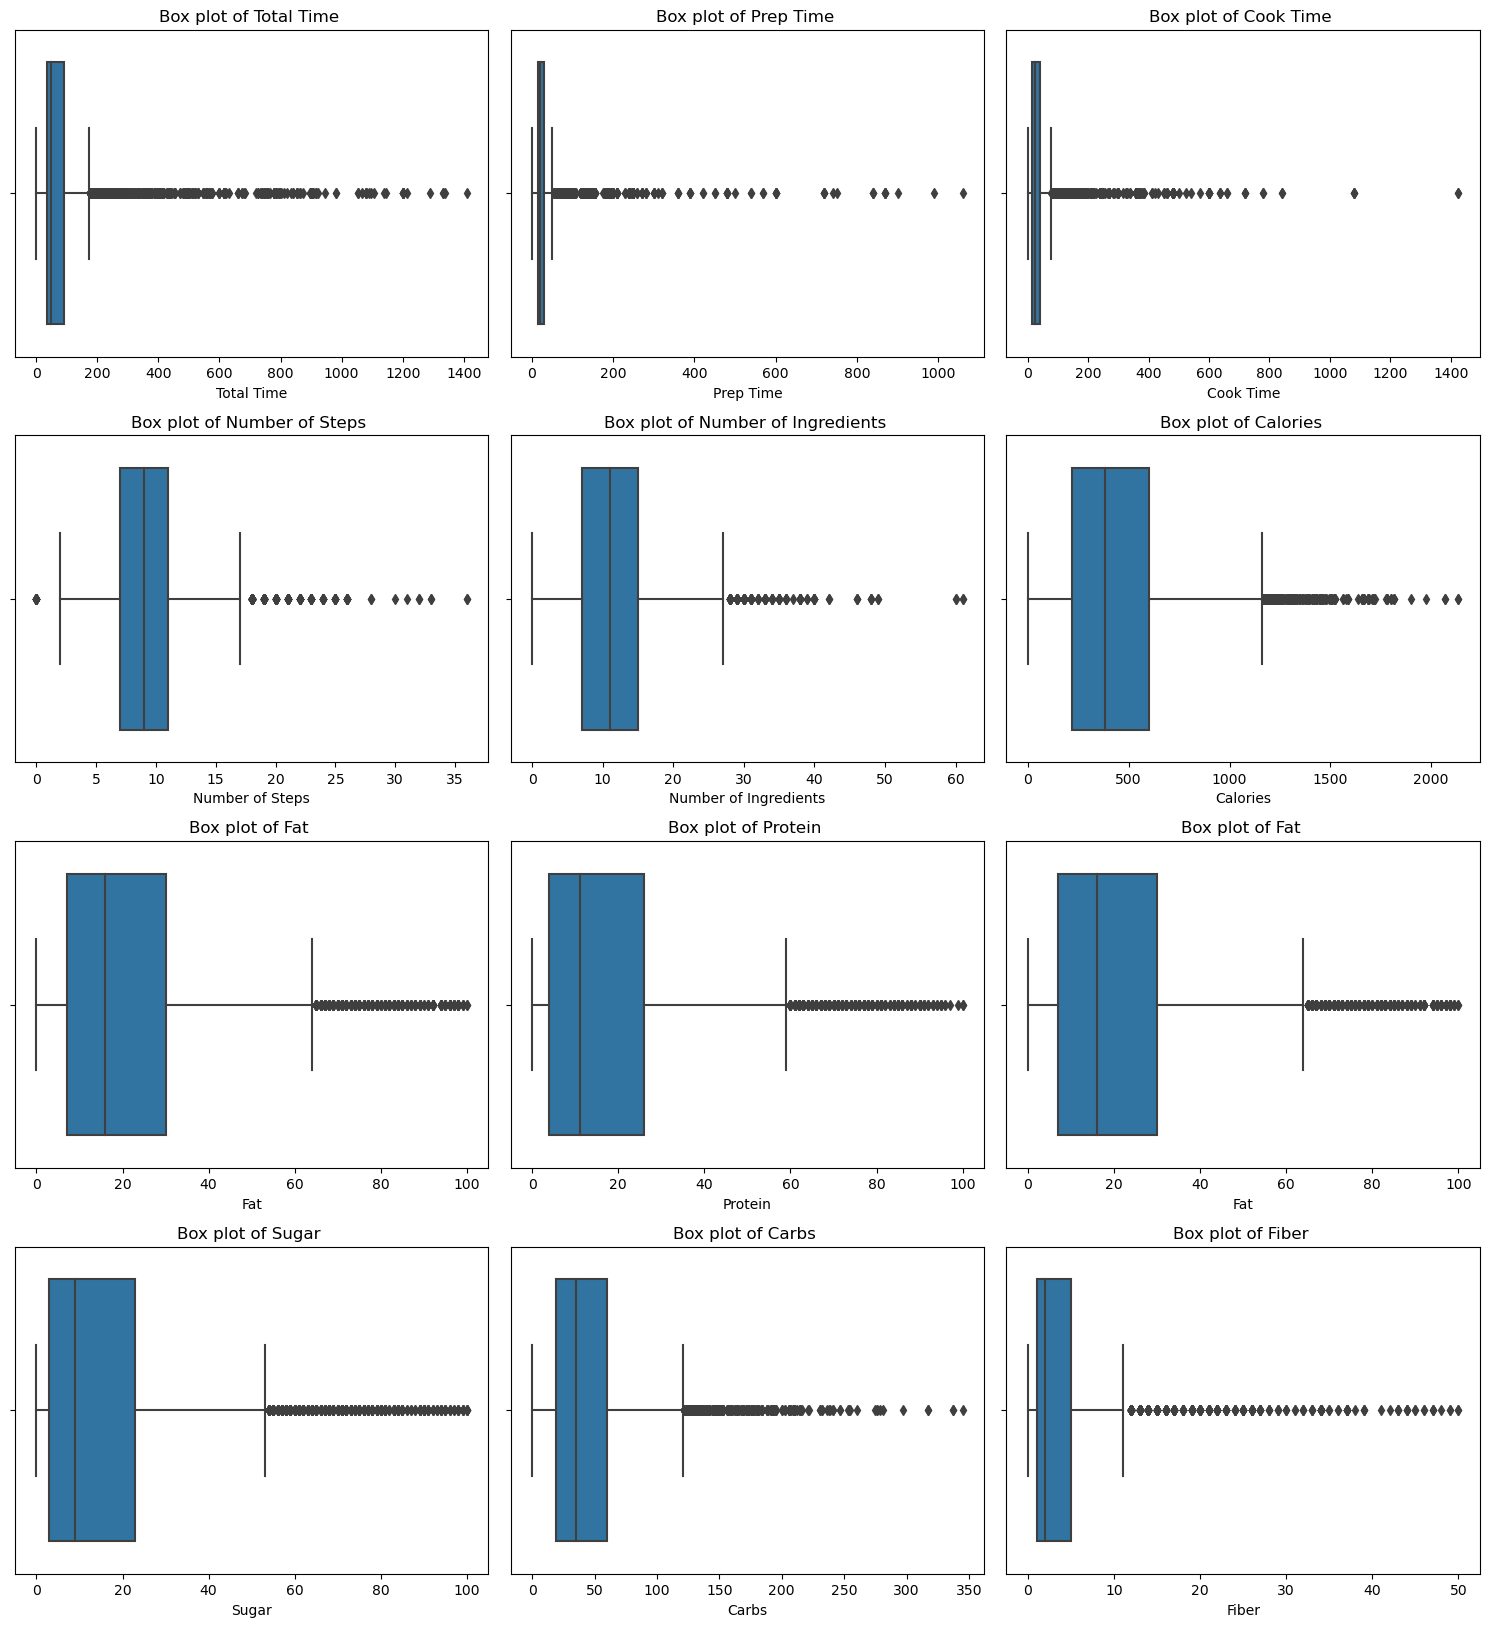

In [45]:
# List of columns to visualize
selected_columns = [
    'Total Time', 'Prep Time', 'Cook Time', 'Number of Steps', 'Number of Ingredients',
    'Calories', 'Fat', 'Protein', 'Fat', 'Sugar', 'Carbs', 'Fiber'
]

# Function to visualize data with box plots
def visualize_data(df, columns, title):
    plt.figure(figsize=(15, 20))
    for i, col in enumerate(columns, 1):
        plt.subplot(len(columns) // 3 + 1, 3, i)
        sns.boxplot(x=df[col])
        plt.title(f'Box plot of {col} {title}')
    plt.tight_layout()
    plt.show()

# Visualize initial data
visualize_data(df_recipes, selected_columns, '')

In [46]:
# Cap outliers using more realistic bounds for cooking times
def cap_outliers(df, cols, upper_bounds=None):
    for col in cols:
        if upper_bounds and col in upper_bounds:
            upper_bound = upper_bounds[col]
            df.loc[df[col] > upper_bound, col] = upper_bound
        else:
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            df.loc[df[col] < lower_bound, col] = lower_bound
            df.loc[df[col] > upper_bound, col] = upper_bound
    return df

# Define realistic upper bounds for time-related columns
upper_bounds = {
    'cook_time': 180,  # 3 hours
    'prep_time': 120,  # 2 hours
    'total_time': 300  # 5 hours
}

# Cap outliers in the selected columns
df_recipes = cap_outliers(df_recipes, selected_columns, upper_bounds)

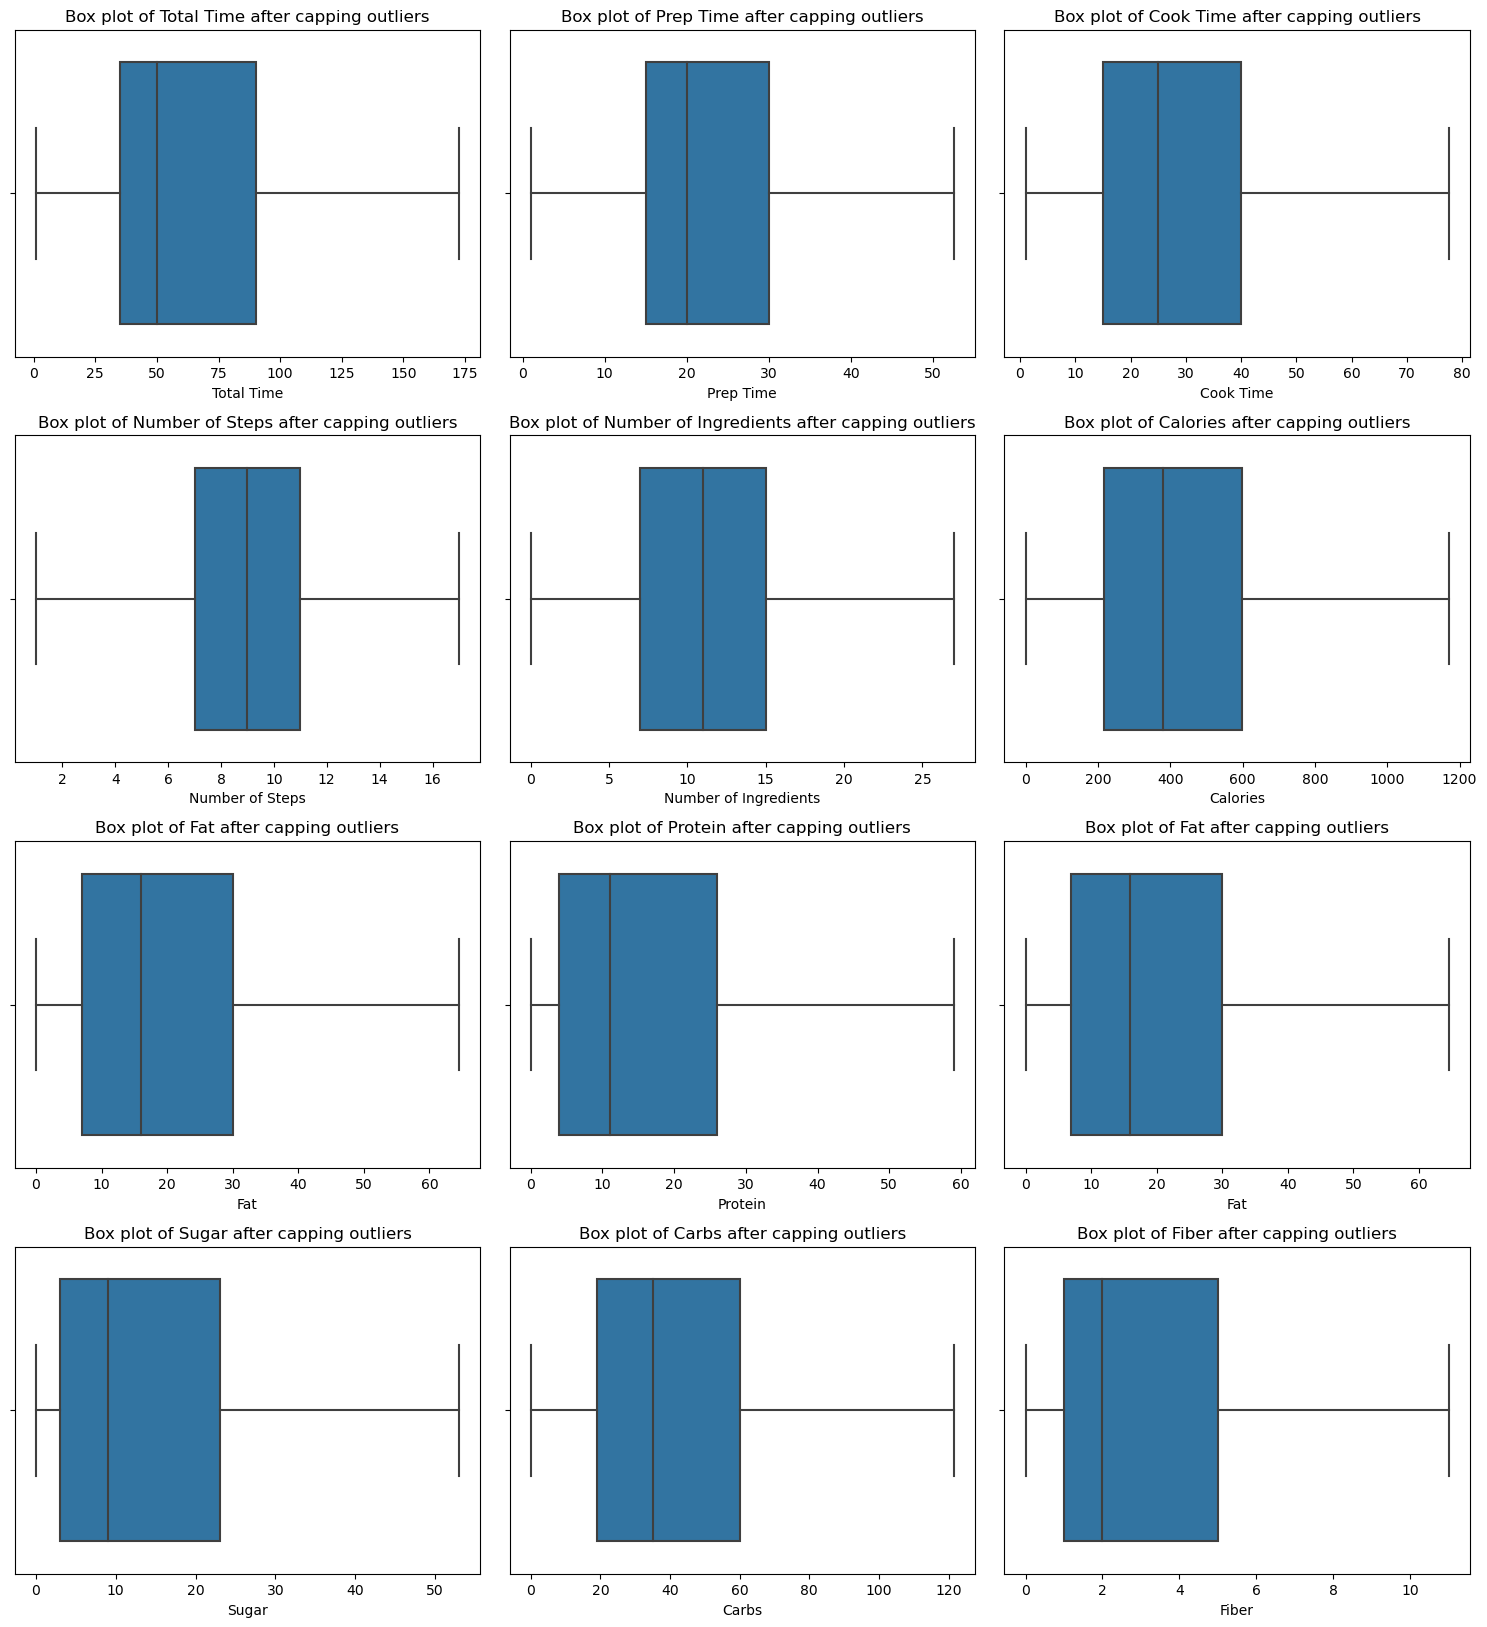

In [47]:
# Visualize data after capping outliers
visualize_data(df_recipes, selected_columns, 'after capping outliers')

In [48]:
df_recipes.describe()

,Role,Score,Total Time,Prep Time,Cook Time,Calories,Fat,Carbs,Fiber,Sugar,Protein,Number of Steps,Number of Ingredients
count,10250.000000,7939.000000,8373.000000,8392.000000,8392.000000,9242.000000,9242.000000,9242.000000,9242.000000,9242.000000,9242.000000,10250.000000,10250.000000
mean,0.315122,89.100768,70.172220,22.631673,29.787893,438.540413,20.405269,43.461859,3.330340,15.368751,17.246051,9.203707,11.635024
std,0.648795,8.964161,49.565581,14.334049,21.375416,284.181610,17.286005,31.658626,3.356831,15.638042,16.925186,3.397075,5.724371
min,0.000000,15.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,0.000000,86.000000,35.000000,15.000000,15.000000,217.000000,7.000000,19.000000,1.000000,3.000000,4.000000,7.000000,7.000000
50%,0.000000,92.000000,50.000000,20.000000,25.000000,380.000000,16.000000,35.000000,2.000000,9.000000,11.000000,9.000000,11.000000
75%,0.000000,95.000000,90.000000,30.000000,40.000000,598.000000,30.000000,60.000000,5.000000,23.000000,26.000000,11.000000,15.000000
max,2.000000,100.000000,172.500000,52.500000,77.500000,1169.500000,64.500000,121.500000,11.000000,53.000000,59.000000,17.000000,27.000000


The box plots show that the outliers have been effectively capped, resulting in more compact and controlled distributions for each column. The data is now better prepared for model training.

### TEST

In [49]:
# Select the columns for KNN imputation
numerical_columns = ['Score', 'Total Time', 'Prep Time', 'Cook Time', 'Fat', 'Calories', 'Sugar', 'Carbs', 'Fiber', 'Protein']

# Ensure all selected columns are numeric
df_recipes[numerical_columns] = df_recipes[numerical_columns].apply(pd.to_numeric, errors='coerce')

In [50]:
# Function to apply KNN imputation for the specified columns
def knn_imputation(df, columns_to_impute, n_neighbors=5):
    # Replace zero values in the specified columns with NaN for imputation
    df[columns_to_impute] = df[columns_to_impute].replace(0, np.nan)
    
    # Apply KNN imputation only to the specified columns
    imputer = KNNImputer(n_neighbors=n_neighbors)
    df[columns_to_impute] = imputer.fit_transform(df[columns_to_impute])
    
    return df

In [68]:
param_grids = {
    'Linear Regression': {
        'model__fit_intercept': [True, False]
    },
    'Random Forest': {
        'model__n_estimators': [50, 100, 200],
        'model__max_depth': [None, 10, 20, 30],
        'model__min_samples_split': [2, 5, 10],
        'model__min_samples_leaf': [1, 2, 4]
    },
    'Gradient Boosting': {
        'model__n_estimators': [50, 100, 200],
        'model__learning_rate': [0.01, 0.1, 0.2],
        'model__max_depth': [3, 5, 7]
    },
    'SVR': {
        'model__kernel': ['linear', 'rbf'],
        'model__C': [0.1, 1, 10],
        'model__gamma': ['scale', 'auto']
    },
    'XGBoost': {
        'model__n_estimators': [50, 100, 200],
        'model__max_depth': [3, 5, 7],
        'model__learning_rate': [0.01, 0.1, 0.2]
    }
}

In [69]:
# Define the models
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(),
    'Gradient Boosting': GradientBoostingRegressor(),
    'SVR': SVR(),
    'XGBoost': XGBRegressor()
}

In [54]:
# Define the vectorizer
vectorizer = TfidfVectorizer()

# Feature numbers and KNN neighbors to test
feature_numbers = [5, 10, 20, 50, 100, 200]
knn_neighbors = [3, 5, 7]

In [55]:
best_models = {}
best_scores = {}

In [84]:
# Function to run the experiment
def run_experiment(X_train, y_train, X_test, y_test, feature_num):
    for model_name in models:
        print(f"Training {model_name}...")
        vectorizer_ing = TfidfVectorizer(max_features=feature_num)
        vectorizer_ins = TfidfVectorizer(max_features=feature_num)
        vectorizer_tag = TfidfVectorizer(max_features=feature_num)
        
        # Fit and transform the text data
        X_train_ing = vectorizer_ing.fit_transform(X_train['Ingredients'])
        X_train_ins = vectorizer_ins.fit_transform(X_train['Preparation Steps'])
        X_train_tag = vectorizer_tag.fit_transform(X_train['Tags'])
        
        X_test_ing = vectorizer_ing.transform(X_test['Ingredients'])
        X_test_ins = vectorizer_ins.transform(X_test['Preparation Steps'])
        X_test_tag = vectorizer_tag.transform(X_test['Tags'])
        
        # Concatenate the text features into a single matrix
        X_train_text = hstack([X_train_ing, X_train_ins, X_train_tag])
        X_test_text = hstack([X_test_ing, X_test_ins, X_test_tag])
        
        # Standardize the numerical features
        scaler = StandardScaler(with_mean=False)
        X_train_num = scaler.fit_transform(X_train[numerical_columns])
        X_test_num = scaler.transform(X_test[numerical_columns])
        
        # Combine text and numerical features
        X_train_combined = hstack([X_train_text, X_train_num])
        X_test_combined = hstack([X_test_text, X_test_num])
        
        pipeline = Pipeline([
            ('model', models[model_name])
        ])
        
        grid_search = GridSearchCV(pipeline, param_grids[model_name], cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=2, return_train_score=True)
        grid_search.fit(X_train_combined, y_train)
        
        best_models[model_name] = grid_search.best_estimator_
        best_scores[model_name] = grid_search.best_score_

        # Evaluate the best model on the test set
        y_pred = best_models[model_name].predict(X_test_combined)
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        print(f"{model_name} MSE: {mse}, R²: {r2}")
        print(f"Best Parameters for {model_name}: {grid_search.best_params_}")

In [85]:
# Split the data into publisher and community member recipes
publisher_recipes = df_recipes[df_recipes['Role'] == 0]
community_recipes = df_recipes[df_recipes['Role'] == 1]

In [ ]:
# Run the experiment for publisher recipes
print("Running experiments for Publisher Recipes")
for feature_num in feature_numbers:
    for n_neighbors in knn_neighbors:
        print(f"\nRunning experiment with {feature_num} features and {n_neighbors} KNN neighbors...\n")
        publisher_recipes_imputed = knn_imputation(publisher_recipes.copy(), numerical_columns, n_neighbors=n_neighbors)
        
        X = publisher_recipes_imputed[['Ingredients', 'Preparation Steps', 'Tags', *numerical_columns]]
        y = publisher_recipes_imputed['Score']
        
        # Split the dataset
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        
        # Run the experiment
        run_experiment(X_train, y_train, X_test, y_test, feature_num)

Running experiments for Publisher Recipes

Running experiment with 5 features and 3 KNN neighbors...

Training Linear Regression...
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Linear Regression MSE: 2.1314718650446655e-09, R²: 0.9999999999707715
Best Parameters for Linear Regression: {'model__fit_intercept': True}
Training Random Forest...
Fitting 5 folds for each of 108 candidates, totalling 540 fits
Random Forest MSE: 0.001670918472652213, R²: 0.9999770869888521
Best Parameters for Random Forest: {'model__max_depth': 10, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2, 'model__n_estimators': 50}
Training Gradient Boosting...
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Gradient Boosting MSE: 0.00021276872246424954, R²: 0.9999970823399289
Best Parameters for Gradient Boosting: {'model__learning_rate': 0.1, 'model__max_depth': 3, 'model__n_estimators': 200}
Training SVR...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
SVR MSE:

Training Linear Regression...
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Linear Regression MSE: 2.9334820623807455e-09, R²: 0.9999999999597736
Best Parameters for Linear Regression: {'model__fit_intercept': True}
Training Random Forest...
Fitting 5 folds for each of 108 candidates, totalling 540 fits
Random Forest MSE: 0.0033242886702062337, R²: 0.9999544146141145
Best Parameters for Random Forest: {'model__max_depth': None, 'model__min_samples_leaf': 4, 'model__min_samples_split': 2, 'model__n_estimators': 100}
Training Gradient Boosting...
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Gradient Boosting MSE: 0.0004471988350421187, R²: 0.9999938676410248
Best Parameters for Gradient Boosting: {'model__learning_rate': 0.1, 'model__max_depth': 3, 'model__n_estimators': 200}
Training SVR...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
SVR MSE: 0.003980050571219811, R²: 0.999945422266496
Best Parameters for SVR: {'model__C': 10, 'model__gamm

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Random Forest MSE: 0.004876937647896704, R²: 0.9999331234117507
Best Parameters for Random Forest: {'model__max_depth': 20, 'model__min_samples_leaf': 4, 'model__min_samples_split': 10, 'model__n_estimators': 200}
Training Gradient Boosting...
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Gradient Boosting MSE: 0.0014272996526932212, R²: 0.9999804276908846
Best Parameters for Gradient Boosting: {'model__learning_rate': 0.1, 'model__max_depth': 3, 'model__n_estimators': 200}
Training SVR...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
SVR MSE: 0.003609858825559501, R²: 0.9999504986407979
Best Parameters for SVR: {'model__C': 1, 'model__gamma': 'scale', 'model__kernel': 'linear'}
Training XGBoost...
Fitting 5 folds for each of 27 candidates, totalling 135 fits
XGBoost MSE: 0.0013985752168374475, R²: 0.9999808215840216
Best Parameters for XGBoost: {'model__learning_rate': 0.1, 'model__max_depth'

In [ ]:
# Run the experiment for community member recipes
print("Running experiments for Community Member Recipes")
for feature_num in feature_numbers:
    for n_neighbors in knn_neighbors:
        print(f"\nRunning experiment with {feature_num} features and {n_neighbors} KNN neighbors...\n")
        community_recipes_imputed = knn_imputation(community_recipes.copy(), numerical_columns, n_neighbors=n_neighbors)
        
        X = community_recipes_imputed[['Ingredients', 'Preparation Steps', 'Tags', *numerical_columns]]
        y = community_recipes_imputed['Score']
        
        # Split the dataset
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        
        # Run the experiment
        run_experiment(X_train, y_train, X_test, y_test, feature_num)

In [ ]:
import pickle 
# Save the trained models to disk
def save_models(models, filename):
    with open(filename, 'wb') as file:
        pickle.dump(models, file)

In [ ]:
# Example usage:
save_models(best_models, 'best_models_publisher.pkl')
# Example usage:
save_models(best_models, 'best_models_community.pkl')

### Handle missing values

In [ ]:
# Function to apply KNN imputation for the specified columns
def knn_imputation(df, columns_to_impute):
    # Replace zero values in the specified columns with NaN for imputation
    df[columns_to_impute] = df[columns_to_impute].replace(0, np.nan)
    
    # Check for missing values before imputation
    missing_values_before = df[columns_to_impute].isnull().sum()
    print("Missing values before imputation:\n", missing_values_before)
    
    # Apply KNN imputation only to the specified columns
    imputer = KNNImputer(n_neighbors=5)
    df[columns_to_impute] = imputer.fit_transform(df[columns_to_impute])
    
    return df

# Select the columns for KNN imputation
numerical_columns = ['Score', 'Total Time', 'Prep Time', 'Cook Time', 'Fat', 'Calories', 'Sugar', 'Carbs', 'Fiber', 'Protein']

# Ensure all selected columns are numeric
df_recipes[numerical_columns] = df_recipes[numerical_columns].apply(pd.to_numeric, errors='coerce')

# Apply KNN imputation to numerical columns
df_recipes = knn_imputation(df_recipes, numerical_columns)

# Verify if there are still missing values
remaining_nans = df_recipes[numerical_columns].isnull().sum()
print("\nRemaining NaNs after imputation:\n", remaining_nans)

In [ ]:
df_recipes.info()

In [ ]:
# Filter rows with missing titles
missing_titles = df_recipes[df_recipes['Recipe Title'].isnull()]

# Display rows with missing titles
print(missing_titles)

The rows are empty and will be removed from the dataframe.

In [ ]:
# Remove rows with missing recipe titles
df_recipes = df_recipes.dropna(subset=['Recipe Title'])

# Verify that rows with missing titles have been removed
print(df_recipes.info())

### Data vecotrization

In [ ]:
df_recipes

In [ ]:
# Create a copy of df_merge for numerical processing
df_numerical = df_recipes.copy()

In [ ]:
# List of text features to vectorize
text_features = ['Recipe Title', 'Ingredients', 'Preparation Steps', 'Tags']

# Function to vectorize text features
def vectorize_text_features(df, text_features):
    vectorizers = {feature: TfidfVectorizer(max_features=20, stop_words='english') for feature in text_features}
    for feature in text_features:
        tfidf_matrix = vectorizers[feature].fit_transform(df[feature].fillna('')).toarray()
        tfidf_df = pd.DataFrame(tfidf_matrix, columns=[f'{feature}_tfidf_{i}' for i in range(tfidf_matrix.shape[1])])
        tfidf_df.index = df.index  # Ensure the indices match
        df = pd.concat([df, tfidf_df], axis=1)
    df.drop(columns=text_features, inplace=True)
    return df, vectorizers

# Vectorize the text features
df_numerical, vectorizers = vectorize_text_features(df_numerical, text_features)

In [ ]:
df_numerical

The summary statistics show that the numerical columns have been successfully standardized, with means close to 0 and standard deviations close to 1. This is expected after applying the StandardScaler.

### Define models and parameters grid

In [ ]:
# Define the parameter grids
param_grids = {
    'Linear Regression': {
        'model__fit_intercept': [True, False],
        'model__normalize': [True, False]
    },
    'Random Forest': {
        'model__n_estimators': [50, 100, 200],
        'model__max_depth': [None, 10, 20, 30],
        'model__min_samples_split': [2, 5, 10],
        'model__min_samples_leaf': [1, 2, 4]
    },
    'Gradient Boosting': {
        'model__n_estimators': [50, 100, 200],
        'model__learning_rate': [0.01, 0.1, 0.2],
        'model__max_depth': [3, 5, 7]
    },
    'SVR': {
        'model__kernel': ['linear', 'rbf'],
        'model__C': [0.1, 1, 10],
        'model__gamma': ['scale', 'auto']
    },
    'XGBoost': {
        'model__n_estimators': [50, 100, 200],
        'model__max_depth': [3, 5, 7],
        'model__learning_rate': [0.01, 0.1, 0.2]
    }
}

## 4. Model training and evaluation

### 4.1 Baseline models

In [ ]:
# Split into publisher-curated and user-generated subsets
publisher_recipes = df_numerical[df_numerical['is_community'] == 0]
user_recipes = df_numerical[df_numerical['is_community'] == 1]

In [ ]:
# Perform 80/20 split for each subset
train_publisher, test_publisher = train_test_split(publisher_recipes, test_size=0.2, random_state=42)
train_user, test_user = train_test_split(user_recipes, test_size=0.2, random_state=42)

In [ ]:
# Define feature columns (all features except 'score' and 'is_community')
all_feature_columns = df_numerical.columns.drop(['score', 'is_community'])

In [ ]:
# Function to train and evaluate a model
def train_and_evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    return mse, r2

##### grid search

In [ ]:
# Initialize models
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42)
}

In [ ]:
# Prepare results dictionary
results = []

# Train and evaluate models for publisher-curated recipes
for model_name, model in models.items():
    mse, r2 = train_and_evaluate_model(model, train_publisher[all_feature_columns], train_publisher['score'], test_publisher[all_feature_columns], test_publisher['score'])
    results.append({'Model': model_name, 'Dataset': 'Publisher-Curated Recipes', 'MSE': mse, 'R²': r2})

# Train and evaluate models for user-generated recipes
for model_name, model in models.items():
    mse, r2 = train_and_evaluate_model(model, train_user[all_feature_columns], train_user['score'], test_user[all_feature_columns], test_user['score'])
    results.append({'Model': model_name, 'Dataset': 'User-Generated Recipes', 'MSE': mse, 'R²': r2})

In [ ]:
# Convert results to a DataFrame for better visualization
results_df = pd.DataFrame(results)

# Display results
print(results_df)


| Model               | Dataset                    | MSE       | R²       |
|---------------------|----------------------------|-----------|----------|
| Linear Regression   | Publisher-Curated Recipes  | 0.549459  | 0.418552 |
| Linear Regression   | User-Generated Recipes     | 1.346859  | -0.055192|
| Random Forest       | Publisher-Curated Recipes  | 0.044056  | 0.953379 |
| Random Forest       | User-Generated Recipes     | 0.387183  | 0.696663 |
| Gradient Boosting   | Publisher-Curated Recipes  | 0.053582  | 0.943299 |
| Gradient Boosting   | User-Generated Recipes     | 0.325095  | 0.745305 |


#### Detailed Analysis

**Linear Regression:**
- **Publisher-Curated Recipes:** MSE = 0.549459, R² = 0.418552
- **User-Generated Recipes:** MSE = 1.346859, R² = -0.055192
- Linear Regression shows moderate performance for publisher-curated recipes but struggles significantly with user-generated recipes, indicating that the linear nature of this model might not be capturing the complexity of the data.

**Random Forest:**
- **Publisher-Curated Recipes:** MSE = 0.044056, R² = 0.953379
- **User-Generated Recipes:** MSE = 0.387183, R² = 0.696663
- Random Forest performs exceptionally well with publisher-curated recipes but has a lower performance with user-generated recipes. This suggests that while it can handle more complex patterns, the variability in user-generated data presents a challenge.

**Gradient Boosting:**
- **Publisher-Curated Recipes:** MSE = 0.053582, R² = 0.943299
- **User-Generated Recipes:** MSE = 0.325095, R² = 0.745305
- Gradient Boosting shows similar trends to Random Forest, performing well on publisher-curated recipes but less so on user-generated recipes. Its iterative approach to reducing errors makes it slightly better suited to handle the complexities of user-generated data compared to Random Forest.

#### Potential Reasons for Discrepancy

1. **Data Quality and Consistency:**
   - Publisher-curated recipes are likely to be more standardized, with consistent formats and higher-quality data. This makes it easier for the model to learn and make accurate predictions.
   - User-generated recipes can vary widely in format, quality, and completeness, making it harder for the model to generalize and predict accurately. 

2. **Sample Size:**
   - If there are significantly more publisher-curated recipes in the training data, the model might be biased towards learning patterns from publisher data, leading to better performance on publisher-curated recipes.

#### Recommendations

1. **Feature Engineering:**
   - Explore additional features or transformations that might better capture the characteristics of user-generated recipes.

2. **Data Augmentation:**
   - Increase the sample size of user-generated recipes, to provide the model with more diverse examples by incorporating additional datasets.

3. **Model Complexity:**
   - Use more complex models or ensemble methods that might capture the variability in user-generated recipes better.

4. **Hyperparameter Tuning:**
   - Perform hyperparameter tuning specifically for the model predicting user-generated recipes to improve its performance.

## 5. Feature engineering

In [ ]:
# Function to select top features for a specific dataset
def select_top_features(data, target, k=20):
    selector = SelectKBest(score_func=f_regression, k=k)
    selector.fit(data, target)
    selected_features = data.columns[selector.get_support()]
    return selected_features, selector.scores_[selector.get_support()]

In [ ]:
# Select top features for user-generated recipes
user_features, user_scores = select_top_features(train_user[all_feature_columns], train_user['score'])
print(f'Selected Features for User-Generated Recipes: {user_features}')

# Select top features for publisher-curated recipes
publisher_features, publisher_scores = select_top_features(train_publisher[all_feature_columns], train_publisher['score'])
print(f'Selected Features for Publisher-Curated Recipes: {publisher_features}')

In [ ]:
# Get the TF-IDF mappings for the text features
def map_tfidf_features(vectorizer, feature_name_prefix):
    feature_names = vectorizer.get_feature_names_out()
    return {f'{feature_name_prefix}{i}': feature_names[i] for i in range(len(feature_names))}

# Assuming 'vectorizers' dictionary exists and contains the fitted vectorizers
name_tfidf_mapping = map_tfidf_features(vectorizers['name'], 'name_tfidf_')
ingredients_tfidf_mapping = map_tfidf_features(vectorizers['flattened_ingredients'], 'flattened_ingredients_tfidf_')
instructions_tfidf_mapping = map_tfidf_features(vectorizers['flattened_instructions'], 'flattened_instructions_tfidf_')
keywords_tfidf_mapping = map_tfidf_features(vectorizers['keywords'], 'keywords_tfidf_')

# Combine all TF-IDF mappings into a single dictionary
tfidf_mappings = {**name_tfidf_mapping, **ingredients_tfidf_mapping, **instructions_tfidf_mapping, **keywords_tfidf_mapping}

In [ ]:
# Function to rename TF-IDF features
def rename_tfidf_features(selected_features, tfidf_mappings):
    return [tfidf_mappings.get(feature, feature) for feature in selected_features]

# Renaming TF-IDF features for user-generated recipes
user_features_renamed = rename_tfidf_features(user_features, tfidf_mappings)

# Renaming TF-IDF features for publisher-curated recipes
publisher_features_renamed = rename_tfidf_features(publisher_features, tfidf_mappings)

In [ ]:
# Function to plot feature importances
def plot_feature_importances(feature_names, feature_scores, title):
    indices = np.argsort(feature_scores)[::-1]
    plt.figure(figsize=(10, 6))
    plt.title(title)
    plt.bar(range(len(indices)), feature_scores[indices], align='center')
    plt.xticks(range(len(indices)), [feature_names[i] for i in indices], rotation=90)
    plt.tight_layout()
    plt.show()

In [ ]:
# Plotting feature importances for publisher-curated recipes
plot_feature_importances(publisher_features_renamed, publisher_scores, "Top 20 Features for Publisher-Curated Recipes")

# Plotting feature importances for user-generated recipes
plot_feature_importances(user_features_renamed, user_scores, "Top 20 Features for User-Generated Recipes")

### Retrain the models on selected features

In [ ]:
# Split the data into training and testing sets using selected features
X_train_user = train_user[user_features]
y_train_user = train_user['score']
X_test_user = test_user[user_features]
y_test_user = test_user['score']

X_train_publisher = train_publisher[publisher_features]
y_train_publisher = train_publisher['score']
X_test_publisher = test_publisher[publisher_features]
y_test_publisher = test_publisher['score']

In [ ]:
# Prepare results dictionary
results_features = []

# Train and evaluate models for publisher-curated recipes
for name, model in models.items():
    mse, r2 = train_and_evaluate_model(model, X_train_publisher, y_train_publisher, X_test_publisher, y_test_publisher)
    results_features.append({'Model': model_name, 'Dataset': 'Publisher-Curated Recipes', 'MSE': mse, 'R²': r2})
    
# Train and evaluate models for user-generated recipes
for name, model in models.items():
    mse, r2 = train_and_evaluate_model(model, X_train_user, y_train_user, X_test_user, y_test_user)
    results_features.append({'Model': model_name, 'Dataset': 'User-Generated Recipes', 'MSE': mse, 'R²': r2})

In [ ]:
# Convert results to a DataFrame for better visualization
results_features = pd.DataFrame(results)

# Display results
print(results_features)

### Summary of Model Performance
### Combined Table

| Features           | Model               | Dataset                    | MSE       | R²       |
|--------------------|---------------------|----------------------------|-----------|----------|
| All Features       | Linear Regression   | Publisher-Curated Recipes  | 0.549459  | 0.418552 |
| All Features       | Linear Regression   | User-Generated Recipes     | 1.346859  | -0.055192|
| All Features       | Random Forest       | Publisher-Curated Recipes  | 0.044056  | 0.953379 |
| All Features       | Random Forest       | User-Generated Recipes     | 0.387183  | 0.696663 |
| All Features       | Gradient Boosting   | Publisher-Curated Recipes  | 0.053582  | 0.943299 |
| All Features       | Gradient Boosting   | User-Generated Recipes     | 0.325095  | 0.745305 |
| Top 20 Features    | Linear Regression   | Publisher-Curated Recipes  | 0.549459  | 0.418552 |
| Top 20 Features    | Linear Regression   | User-Generated Recipes     | 1.346859  | -0.055192|
| Top 20 Features    | Random Forest       | Publisher-Curated Recipes  | 0.044056  | 0.953379 |
| Top 20 Features    | Random Forest       | User-Generated Recipes     | 0.387183  | 0.696663 |
| Top 20 Features    | Gradient Boosting   | Publisher-Curated Recipes  | 0.053582  | 0.943299 |
| Top 20 Features    | Gradient Boosting   | User-Generated Recipes     | 0.325095  | 0.745305 |

### Comparison

1. **Performance with All Features**:
   - **Random Forest**: Exhibited the best performance overall, especially for publisher-curated recipes with a low MSE of 0.044056 and a high R² of 0.953379. It also performed reasonably well for user-generated recipes with an MSE of 0.387183 and an R² of 0.696663.
   - **Gradient Boosting**: Showed strong performance for both types of recipes, slightly behind Random Forest, with an MSE of 0.053582 and R² of 0.943299 for publisher-curated recipes, and an MSE of 0.325095 and R² of 0.745305 for user-generated recipes.
   - **Linear Regression**: Had the weakest performance among the three, with an MSE of 0.549459 and R² of 0.418552 for publisher-curated recipes, and an MSE of 1.346859 and R² of -0.055192 for user-generated recipes.

2. **Performance After Feature Selection**:
   - **Random Forest**: Maintained strong performance after feature selection, particularly for publisher-curated recipes, where the MSE remained 0.044056 and R² stayed at 0.953379. For user-generated recipes, the performance slightly improved with an MSE of 0.387183 and R² of 0.696663.
   - **Gradient Boosting**: Similarly maintained strong performance after feature selection, with the MSE for publisher-curated recipes at 0.053582 and R² at 0.943299, and for user-generated recipes at an MSE of 0.325095 and R² of 0.745305.
   - **Linear Regression**: Showed no change in performance after feature selection, indicating that the selected features did not impact the model's predictive capability. The MSE and R² remained 0.549459 and 0.418552 for publisher-curated recipes, and 1.346859 and -0.055192 for user-generated recipes.

### Observations

- **Publisher-Curated Recipes**: Random Forest and Gradient Boosting performed exceptionally well with both all features and top 20 features, indicating that the models can effectively capture the patterns in the data.
- **User-Generated Recipes**: Both models showed consistent performance with both all features and top 20 features, suggesting that the selected features are adequate in capturing the variability and complexity of user-generated recipes.
- **Feature Selection Impact**: The feature selection process did not negatively impact model performance for both types of recipes, indicating that the top 20 features selected are sufficiently representative of the entire feature set.

### Recommendations

- **Data Augmentation**: Increase the sample size of user-generated recipes to provide the models with more diverse examples by incorporating additional datasets.
- **Model Complexity**: Consider using more complex models or ensemble methods to better capture the variability in user-generated recipes.
- **Hyperparameter Tuning**: Perform hyperparameter tuning specifically for user-generated recipes to improve the models' performance.

## 6. Data augmentation

### Load a community recipes dataset

In [ ]:
df_community = pd.read_csv('Data/community_recipes_ks.csv')

In [ ]:
df_community

In [ ]:
# List all column names in df_community
community_columns = df_community.columns.tolist()
print("Column names in df_community:", community_columns)

In [ ]:
# Rename columns in df_community to match those in train_user
df_community.rename(columns={
    'recipe_title': 'name',
    'global_likes': 'ratings_positive',  # Assuming global_likes is similar to positive ratings
    'preparation': 'prep_time',
    'baking': 'cook_time',
    'resting': 'rest_time',  # If rest time exists in the original dataset; otherwise, handle accordingly
    'ingredients': 'flattened_ingredients',
    'steps': 'flattened_instructions',
    'tags': 'keywords',
    'Cal': 'calories',
    'Fat': 'fat',
    'Protein': 'protein',
    'Carb': 'carbohydrates'
}, inplace=True)

In [ ]:
# Add missing columns with NaNs to signify missing data
default_values = {
    'is_community': 1,
    'ratings_negative': np.nan,
    'sugar': np.nan,
    'fiber': np.nan,
    'num_ingredients': df_community['flattened_ingredients'].apply(lambda x: len(x.split(','))),
    'num_steps': df_community['flattened_instructions'].apply(lambda x: len(x.split('|')))
}

In [ ]:
for column, default_value in default_values.items():
    if column not in df_community.columns:
        df_community[column] = default_value

In [ ]:
# Ensure all columns are in the same order as train_user
required_columns = ['is_community', 'name', 'flattened_ingredients', 'flattened_instructions', 'keywords',
                    'cook_time', 'prep_time', 'total_time', 'ratings_negative', 'ratings_positive',
                    'protein', 'fat', 'calories', 'sugar', 'carbohydrates', 'fiber', 'num_ingredients', 'num_steps']

In [ ]:
for column in required_columns:
    if column not in df_community.columns:
        df_community[column] = np.nan  # Add any truly missing columns with default values

In [ ]:
df_community = df_community[required_columns]

In [ ]:
df_community

### Clean up 

In [ ]:
# Clean up the keywords column
df_community['keywords'] = df_community['keywords'].str.replace('#', '').str.strip().str.lower()

In [ ]:
# Clean up time columns to remove the 'min.' suffix and convert to numeric
time_columns = ['prep_time', 'cook_time', 'total_time']

def clean_time_column(column):
    if column in df_community.columns:
        # Replace 'min.' and 'min' suffix and strip whitespace
        df_community[column] = df_community[column].astype(str).str.replace('min.', '').str.replace('min', '').str.strip()
        # Convert to numeric, coercing errors to NaN
        df_community[column] = pd.to_numeric(df_community[column], errors='coerce')

for col in time_columns:
    clean_time_column(col)

# Check the cleaned up time columns
print("Cleaned time columns:\n", df_community[time_columns].head())
print("Data types after cleaning time columns:\n", df_community[time_columns].dtypes)
print("NaN values in cleaned time columns:\n", df_community[time_columns].isna().sum())

In [ ]:
# Compute total_time as the sum of prep_time and cook_time
df_community['total_time'] = df_community['prep_time'] + df_community['cook_time']

In [ ]:
df_community

### Handle outliers

In [ ]:
# Visualize initial data (optional)
selected_columns = [
    'cook_time', 'prep_time', 'total_time',
    'ratings_negative', 'ratings_positive', 'protein',
    'fat', 'calories', 'sugar', 'carbohydrates', 'fiber'
]

In [ ]:
# Check data type for each column in df_community
column_data_types = df_community.dtypes
print("Column data types in df_community:\n", column_data_types)

In [ ]:
# Convert columns to numeric where applicable
numeric_columns = [
    'cook_time', 'prep_time', 'total_time', 'ratings_negative', 'ratings_positive',
    'protein', 'fat', 'calories', 'sugar', 'carbohydrates', 'fiber', 'num_ingredients', 'num_steps'
]

df_community[numeric_columns] = df_community[numeric_columns].apply(pd.to_numeric, errors='coerce')

# Verify the data types again after renaming and adding columns
column_data_types_after = df_community.dtypes
print("Column data types in df_community after processing:\n", column_data_types_after)

In [ ]:
# Check for NaN values in each column
nan_counts = df_community.isna().sum()
print("NaN values in df_community:\n", nan_counts)

In [ ]:
# Visualize initial data (optional)
selected_columns = [
    'cook_time', 'prep_time', 'total_time'
    ]

visualize_data(df_community, selected_columns, '')

In [ ]:
# Cap outliers in the selected columns
df_community = cap_outliers(df_community, selected_columns, upper_bounds)

# Visualize data after capping outliers (optional)
visualize_data(df_community, selected_columns, 'after capping outliers')

### Merge the datasets

In [ ]:
df_numerical_2 = df_merge.copy()

df_combined = pd.concat([df_numerical_2, df_community], ignore_index=True)

df_combined

### Vectorize the data

In [ ]:
# List of text features to vectorize
text_features = ['name', 'flattened_ingredients', 'flattened_instructions', 'keywords']

# Function to vectorize text features
def vectorize_text_features(df, text_features, vectorizers=None):
    if vectorizers is None:
        vectorizers = {feature: TfidfVectorizer(max_features=20, stop_words='english') for feature in text_features}
    for feature in text_features:
        tfidf_matrix = vectorizers[feature].fit_transform(df[feature].fillna('')).toarray()
        tfidf_df = pd.DataFrame(tfidf_matrix, columns=[f'{feature}_tfidf_{i}' for i in range(tfidf_matrix.shape[1])])
        tfidf_df.index = df.index  # Ensure the indices match
        df = pd.concat([df, tfidf_df], axis=1)
    df.drop(columns=text_features, inplace=True)
    return df, vectorizers

# Vectorize the text features
df_community, vectorizers = vectorize_text_features(df_community, text_features)

In [ ]:
df_community

### Standardize data

In [ ]:
# List of columns to standardize
columns_to_standardize = [
    'cook_time', 'prep_time', 'total_time', 'ratings_negative', 'ratings_positive',
    'protein', 'fat', 'calories', 'sugar', 'carbohydrates', 'fiber', 'num_ingredients', 'num_steps'
]

# Standardize only the selected columns
scaler = StandardScaler()
df_community[columns_to_standardize] = scaler.fit_transform(df_community[columns_to_standardize])

# Verify standardization
print(df_community[columns_to_standardize].describe())

## 5. Test model on unseen data

In [ ]:
# Unseen test recipe data
test_recipe = {
    'is_community': 1,
    'name': 'Chocolate Cake',
    'flattened_ingredients': 'flour, sugar, cocoa powder, baking powder, eggs, milk, butter',
    'flattened_instructions': 'Mix ingredients, bake at 350 degrees for 30 minutes',
    'keywords': 'cake, dessert, chocolate',
    'cook_time': 30,
    'prep_time': 15,
    'total_time': 45,
    'ratings_negative': 5,
    'ratings_positive': 50,
    'protein': 5,
    'fat': 20,
    'calories': 300,
    'sugar': 30,
    'carbohydrates': 50,
    'fiber': 2,
    'num_ingredients': 7,
    'num_steps': 3
}

# Convert the test recipe to a DataFrame
test_recipe_df = pd.DataFrame([test_recipe])

# Ensure all required features are present in the test DataFrame
for feature in user_features:
    if feature not in test_recipe_df.columns:
        test_recipe_df[feature] = 0

# Select features for user-generated recipes
X_test_recipe_user = test_recipe_df[user_features]

# Function to make predictions on the test recipe
def predict_recipe_score(models, X_test):
    predictions = {}
    for name, model in models.items():
        predictions[name] = model.predict(X_test)[0]
    return predictions

# Train the models using existing training data
for name, model in models.items():
    model.fit(X_train_user, y_train_user)

# Predict the score for the test recipe
predicted_scores = predict_recipe_score(models, X_test_recipe_user)

print(f'Predicted Scores for the Test Recipe: {predicted_scores}')

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Unseen test recipe data
test_recipe = {
    'is_community': 1,
    'name': 'Chocolate Cake',
    'flattened_ingredients': 'flour, sugar, cocoa powder, baking powder, eggs, milk, butter',
    'flattened_instructions': 'Mix ingredients, bake at 350 degrees for 30 minutes',
    'keywords': 'cake, dessert, chocolate',
    'cook_time': 30,
    'prep_time': 15,
    'total_time': 45,
    'ratings_negative': 5,
    'ratings_positive': 50,
    'protein': 5,
    'fat': 20,
    'calories': 300,
    'sugar': 30,
    'carbohydrates': 50,
    'fiber': 2,
    'num_ingredients': 7,
    'num_steps': 3
}

# Convert the test recipe to a DataFrame
test_recipe_df = pd.DataFrame([test_recipe])

# Ensure all required features are present in the test DataFrame
for feature in user_features:
    if feature not in test_recipe_df.columns:
        test_recipe_df[feature] = 0

# Select features for user-generated recipes
X_test_recipe_user = test_recipe_df[user_features]

# Assuming the scaler used during training is available
scaler = StandardScaler()

# Fit the scaler on the training data (This should have been done during the initial training)
X_train_user_scaled = scaler.fit_transform(X_train_user)
X_test_recipe_user_scaled = scaler.transform(X_test_recipe_user)

# Function to make predictions on the test recipe
def predict_recipe_score(models, X_test):
    predictions = {}
    for name, model in models.items():
        predictions[name] = model.predict(X_test)[0]
    return predictions

# Train the models using existing training data
for name, model in models.items():
    model.fit(X_train_user_scaled, y_train_user)

# Predict the score for the test recipe
predicted_scores = predict_recipe_score(models, X_test_recipe_user_scaled)

print(f'Predicted Scores for the Test Recipe: {predicted_scores}')
